In [334]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
import pycatch22 as catch22
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer, LabelEncoder
from metric_learn import MMC_Supervised
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from collections import defaultdict
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from pysindy.feature_library import CustomLibrary, GeneralizedLibrary, TensoredLibrary
from sklearn.metrics import log_loss

In [2]:
class featureSpace:
    def __init__(self):
        self.rs = None # fitted robust scaler
        self.mm = None # fitted minMax scaler
        self.calDataNorm = None # normalized calibration data
        self.calDataTS = None # time series calibration data
        self.testDataNorm = None # normalized projected data
        self.testDataTS = None # time series projected data
        self.epsilon = None # tolerance threshold 
        self.learnedMetric = None # metric function learned from calibration data
        self.pca_calibrated = None # low dimensional embedding of the calibrated space
        self.sig = FunctionTransformer(self.sigmoid, kw_args={'theta': 1.35})
        self.pca_fit = None
        self.epsilon = 1 # optimal threshold
    
    @staticmethod
    def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))

    def fit(self, cal_samples, cal_ts):
        """Normalize the calibration data"""
        self.calDataTs = cal_ts
        self.rs = RobustScaler().fit(cal_samples.iloc[:,:22])
        rs_transformed = self.rs.transform(cal_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        self.mm = MinMaxScaler().fit(sig_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.calDataNorm = pd.DataFrame(mm_transformed)
        self.calDataNorm['N'] = cal_samples['N'].values
        self.calDataNorm['eta'] = cal_samples['eta'].values
        self.calDataNorm['mu'] = cal_samples['mu'].values
        self.calDataNorm['model'] = cal_samples['model'].values
        self.pca_fit = PCA(n_components=2).fit(self.calDataNorm.iloc[:,:22])
    
    # function to evaluate the trained space using new data - to be used with external eval function which
    # feeds in new training data, test data and the log/loss + accuracy is returned for each iteration of a loop
    def evaluate(self, test_samples, test_ts, radii):
        """Evaluate the calibrated space on new data
        Args:
            test_samples (pd.DataFrame): new data to be evaluated
            test_ts (pd.DataFrame): time series data for new data
            radii (list): list of radii to be evaluated
        Returns:
            (pd.DataFrame): dataframe containing the log loss and accuracy for each radius
            Predicted probabilities for each sample for each radius
            """
        self.testDataTS = test_ts
        rs_transformed = self.rs.transform(test_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.testDataNorm = pd.DataFrame(mm_transformed)
        self.testDataNorm['N'] = test_samples['N'].values
        self.testDataNorm['eta'] = test_samples['eta'].values
        self.testDataNorm['mu'] = test_samples['mu'].values
        self.testDataNorm['model'] = test_samples['model'].values
        
        # fit ABC radius Classifier and evaluate
        acc = list()
        predicted_proba = list() # list of predicted probabilities for each test sample
        logloss_vals = list()
        for r in radii:
            abc = RadiusNeighborsClassifier(radius=r, outlier_label='most_frequent')
            abc.fit(self.calDataNorm.iloc[:,:22], self.calDataNorm['model'])
            y_pred = abc.predict_proba(self.testDataNorm.iloc[:,:22])
            predicted_proba.append(y_pred)
            logloss_vals.append(log_loss(self.testDataNorm['model'], y_pred))
            acc.append(abc.score(self.testDataNorm.iloc[:,:22], self.testDataNorm['model']))
        results = pd.DataFrame({'radius': radii, 'accuracy': acc, 'logloss': logloss_vals})
        return results, predicted_proba

    # function to compute the distributions of pairwise distances within and between classes in the calibrated space
    #def pairwiseDist(self, showPlot = True):


    def predict(self, proj_samples, proj_ts, showPlot=False): # project new data into the calibrated space
        self.projDataTS = proj_ts
        rs_transformed = self.rs.transform(proj_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.projDataNorm = pd.DataFrame(mm_transformed)
        self.projDataNorm['N'] = proj_samples['N'].values
        self.projDataNorm['eta'] = proj_samples['eta'].values
        self.projDataNorm['mu'] = proj_samples['mu'].values
        self.projDataNorm['model'] = proj_samples['model'].values
        # project new data into calibrated space
        #predicted_proba = list()
        abc = RadiusNeighborsClassifier(radius=self.epsilon, outlier_label='most_frequent')
        abc.fit(self.calDataNorm.iloc[:,:22], self.calDataNorm['model'])
        y_pred = abc.predict_proba(self.projDataNorm.iloc[:,:22])

        if showPlot:
            fig = plt.figure(figsize=(8,5))
            plt.ylabel('P(M|D)', fontsize=15)
            plt.xlabel('Model', fontsize=15)
            models = abc.classes_
            plt.title(f"True = {proj_samples['model'].values[0]}, Predicted = {abc.predict(self.projDataNorm.iloc[:,:22])[0]}, $\epsilon = {self.epsilon}$", fontsize=15)
            sns.barplot(x=models, y=y_pred[0])
            plt.show()
        
        return [y_pred, abc.predict(self.projDataNorm.iloc[:,:22]), abc.classes_]


    def pcaViz(self, return_df = False): # generalize to other projection technqiues
        """Visualize the calibrated space in 2D using PCA"""
        pca_calibrated = self.pca_fit.transform(self.calDataNorm.iloc[:,:22])
        plt.figure(figsize=(12,8))
        plt.title('Unoptimised Space, PCA')
        sns.scatterplot(x=pca_calibrated[:,0], y=pca_calibrated[:,1], hue=self.calDataNorm['model'], s=3 )
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.show()
        if return_df:
            pca_calibrated = pd.DataFrame(pca_calibrated).rename(columns={0:'PC1', 1:'PC2'})
            pca_calibrated['N'] = self.calDataNorm['N']
            pca_calibrated['eta'] = self.calDataNorm['eta']
            pca_calibrated['mu'] = self.calDataNorm['mu']
            pca_calibrated['model'] = self.calDataNorm['model']
            return pca_calibrated

    def getDistances(self):
        features = self.calDataNorm.iloc[:, 0:22]
        classes = self.calDataNorm['model']

        # Split the dataset into different classes
        class_data = defaultdict(list)
        for idx, row in df.iterrows():
            class_data[row['model']].append(row[:22].values)

        # Calculate pairwise distances within each class
        intra_class_distances = {}
        for class_label, feature_vectors in class_data.items():
            intra_class_distances[class_label] = pairwise_distances(feature_vectors)

        # Calculate pairwise distances between different classes
        inter_class_distances = defaultdict(dict)
        for class_label_1, feature_vectors_1 in class_data.items():
            for class_label_2, feature_vectors_2 in class_data.items():
                if class_label_1 != class_label_2:
                    inter_class_distances[class_label_1][class_label_2] = pairwise_distances(feature_vectors_1, feature_vectors_2)

        return intra_class_distances, inter_class_distances
        
    def setEpsilon(self, epsilon):
        """Manually set the tolerance threshold"""
        self.epsilon = epsilon

In [3]:
class LogMap:
    def __init__(self):
        self.mu = None
        self.model = 'LogMap'
        self.transients = 1000
        # store sampling range
        self.mu_min = 2.5
        self.mu_max = 3.95
    
    def set_mu(self, mu):
        self.mu = mu
    
    # generate from deterministic logmap with measurement noise
    def generate_deterministic(self, N, eta_measurement):
        x = np.zeros((N+self.transients, 2))
        x[0] = [np.random.uniform(low=0, high=0.5), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = self.mu * x[i-1, 0] * (1-x[i-1, 0])
            x[i, 1] = self.mu

        # add measurement noise
        noise = np.zeros((N, 2))
        noise[:, 0] = eta_measurement * np.random.randn(N)

        return x[self.transients:] + noise
    
    # generate from logmap with intrinsic process noise (and measurement noise)
    def generate_stochastic(self, N, eta_intrinsic, eta_measurement=None):
        x = np.zeros((N+self.transients, 2))
        x[0] = [np.random.uniform(low=0, high=0.5), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = np.maximum(np.minimum(self.mu * x[i-1, 0] * (1 - x[i - 1, 0]) + eta_intrinsic * np.random.randn(), 1), 0)
            x[i, 1] = self.mu
        
        # add measurement noise if specified
        if eta_measurement:
            noise = np.zeros((N, 2))
            noise[:, 0] = eta_measurement * np.random.randn(N)
            return x[self.transients:] + noise
        else:
            return x[self.transients:]

class HenonMap:
    def __init__(self):
        self.mu = None
        self.model = 'HenonMap'
        self.transients = 1000
        self.b = 0.3
        # store sampling range
        self.mu_min = 0.1
        self.mu_max = 1.0
    
    def set_mu(self, mu):
        self.mu = mu

    # generate data such that it is also compatible with SINDy
    def generate_deterministic(self, N, eta_measurement):
        x = np.zeros((N + self.transients, 3))
        x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = 1 - self.mu * x[i-1, 0]**2 + x[i-1, 1]
            x[i, 1] = self.b * x[i-1, 0] 
            x[i, 2] = self.mu

        # add measurement noise
        noise = np.zeros((N, 3))
        noise[:, :2] = eta_measurement * np.random.randn(N,2)

        return x[self.transients:] + noise
    
    def generate_stochastic(self, N, eta_intrinsic, eta_measurement=None):
        x = np.zeros((N + self.transients, 3))
        x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = 1 - self.mu * x[i-1, 0]**2 + x[i-1, 1] + eta_intrinsic * np.random.randn()
            x[i, 1] = self.b * x[i-1, 0] + eta_intrinsic * np.random.randn()
            x[i, 2] = self.mu
        
        # add measurement noise
        if eta_measurement:
            noise = np.zeros((N, 3))
            noise[:, :2] = eta_measurement * np.random.randn(N)
            return x[self.transients:] + noise
        else:
            return x[self.transients:]

class BurgersMap:
    def __init__(self):
        self.mu = None
        self.model = 'BurgersMap'
        self.transients = 1000
        self.a = 0.75
        # store sampling range
        self.mu_min = 0.9
        self.mu_max = 1.8

    def set_mu(self, mu):
        self.mu = mu
    
    # generate data such that it is also compatible with SINDy
    def generate_deterministic(self, N, eta_measurement):
        x = np.zeros((N + self.transients, 3))
        x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = self.a * x[i-1, 0] - x[i-1,1]**2 
            x[i, 1] = self.mu * x[i-1, 1] + x[i-1, 0] * x[i-1, 1]
            x[i, 2] = self.mu
        
        # add measurement noise
        noise = np.zeros((N, 3))
        noise[:, :2] = eta_measurement * np.random.randn(N,2)
        return x[self.transients:] + noise
    
    def generate_stochastic(self, N, eta_intrinsic, eta_measurement=None):
        x = np.zeros((N + self.transients, 3))
        x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = self.a * x[i-1, 0] - x[i-1,1]**2 + eta_intrinsic * np.random.randn()
            x[i, 1] = self.mu * x[i-1, 1] + x[i-1, 0] * x[i-1, 1] + eta_intrinsic * np.random.randn()
            x[i, 2] = self.mu
        
        # add measurement noise
        if eta_measurement:
            noise = np.zeros((N, 3))
            noise[:, :2] = eta_measurement * np.random.randn(N,2)
            return x[self.transients:] + noise
        else:
            return x[self.transients:]

class CubicMap:
    def __init__(self):
        self.mu = None
        self.model = 'CubicMap'
        self.transients = 1000
        # store sampling range
        self.mu_min = 1.8
        self.mu_max = 3.0
    
    def set_mu(self, mu):
        self.mu = mu

    # generate data such that it is also compatible with SINDy
    def generate_deterministic(self, N, eta_measurement):
            x = np.zeros((N + self.transients, 2))
            x[0] = [np.random.uniform(low=0.001, high=0.01), self.mu]
            for i in range(1, N+self.transients):
                x[i, 0] =  self.mu * x[i-1, 0] * (1-x[i-1, 0]**2)
                x[i, 1] =  self.mu
            
            # add measurement noise
            noise = np.zeros((N, 1))
            noise[:, 0] = eta_measurement * np.random.randn(N)
            return x[self.transients:] + noise
    
    def generate_stochastic(self, N, eta_intrinsic, eta_measurement=None):
            x = np.zeros((N + self.transients, 2))
            x[0] = [np.random.uniform(low=0.001, high=0.01), self.mu]
            for i in range(1, N+self.transients):
                x[i, 0] =  self.mu * x[i-1, 0] * (1-x[i-1, 0]**2) + eta_intrinsic * np.random.randn()
                x[i, 1] =  self.mu
            
            # add measurement noise
            if eta_measurement:
                noise = np.zeros((N, 1))
                noise[:, 0] = eta_measurement * np.random.randn(N)
                return x[self.transients:] + noise
            else:
               return x[self.transients:] 
         
class TinkerBellMap:
    # https://www.mdpi.com/2076-3417/8/12/2640
    def __init__(self):
        self.mu = None
        self.model = 'TinkerBellMap'
        self.transients = 1000
        self.mu_min = 0.1 # here mu (critical param is arbitrarily set to c as per Sprott's definition)
        self.mu_max = 1.6
        self.a = 0.9
        self.b = -0.6013
        self.d = 0.5 
    
    def set_mu(self, mu):
        self.mu = mu

    def generate_deterministic(self, N, eta_measurement):
            x = np.zeros((N + self.transients, 3))
            x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
            for i in range(1, N+self.transients):
                x[i, 0] =  x[i-1, 0]**2 - x[i-1, 1]**2 + self.a * x[i-1, 0] + self.b * x[i-1, 1]
                x[i, 1] =  2 * x[i-1, 0] * x[i-1, 1] + self.mu * x[i-1, 0] + self.d * x[i-1, 1]
                x[i, 2] =  self.mu
            
            # add measurement noise
            noise = np.zeros((N, 3))
            noise[:, :2] = eta_measurement * np.random.randn(N,2)
            return x[self.transients:] + noise

    # generate data such that it is also compatible with SINDy
    def generate_stochastic(self, N, eta_intrinsic, eta_measurement=None):
            x = np.zeros((N + self.transients, 3))
            x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
            for i in range(1, N+self.transients):
                x[i, 0] =  x[i-1, 0]**2 - x[i-1, 1]**2 + self.a * x[i-1, 0] + self.b * x[i-1, 1] + eta_intrinsic * np.random.randn()
                x[i, 1] =  2 * x[i-1, 0] * x[i-1, 1] + self.mu * x[i-1, 0] + self.d * x[i-1, 1] + eta_intrinsic * np.random.randn()
                x[i, 2] =  self.mu
            
            # add measurement noise
            if eta_measurement:
                noise = np.zeros((N, 3))
                noise[:, :2] = eta_measurement * np.random.randn(N,2)
                return x[self.transients:] + noise
            else:
                return x[self.transients:]
    
         

In [4]:
def generate_LogMap(N_val, eta_val):
    # generate samples from a particular map for comparison between methods
    # return sols list (ts) for SINDy and df for our method
    mus = [2.5, 2.75, 3, 3.25, 3.5, 3.75, 3.8, 3.85, 3.9, 3.95] # mu windows to sample from - taken from SINDy paper
    sols_list = list()
    for mu in mus:
        x = LogMap()
        x.set_mu(mu)
        sol = x.generate_deterministic(N_val, eta_val)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features)
    df['N'] = [N_val for i in range(len(sols_list))]
    df['mu'] = mus
    df['eta'] = [eta_val for i in range(len(sols_list))]
    df['model'] = ['LogMap' for i in range(len(sols_list))] 
    ts = sols_list
    return df, ts

def generate_HenonMap(N_val, eta_val):
    # generate samples from a particular map for comparison between methods
    # return sols list (ts) for SINDy and df for our method
    mus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
    sols_list = list()
    for mu in mus:
        x = HenonMap()
        x.set_mu(mu)
        sol = x.generate_deterministic(N_val, eta_val)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features)
    df['N'] = [N_val for i in range(len(sols_list))]
    df['mu'] = mus
    df['eta'] = [eta_val for i in range(len(sols_list))]
    df['model'] = ['HenonMap' for i in range(len(sols_list))] 
    ts = sols_list
    return df, ts

def generate_BurgersMap(N_val, eta_val, seed=None):
    mus = [0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.65, 1.7]
    sols_list = list()
    for mu in mus:
        x = BurgersMap()
        x.set_mu(mu)
        sol = x.generate_deterministic(N_val, eta_val)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features)
    df['N'] = [N_val for i in range(len(sols_list))]
    df['mu'] = mus
    df['eta'] = [eta_val for i in range(len(sols_list))]
    df['model'] = ['BurgersMap' for i in range(len(sols_list))] 
    ts = sols_list
    return df, ts

def generate_CubicMap(N_val, eta_val, seed=None):
    mus = [1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7]
    sols_list = list()
    for mu in mus:
        x = CubicMap()
        x.set_mu(mu)
        sol = x.generate_deterministic(N_val, eta_val)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features)
    df['N'] = [N_val for i in range(len(sols_list))]
    df['mu'] = mus
    df['eta'] = [eta_val for i in range(len(sols_list))]
    df['model'] = ['CubicMap' for i in range(len(sols_list))] 
    ts = sols_list
    return df, ts

def generate_TinkerBellMap(N_val, eta_val, seed=None):
    mus = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
    sols_list = list()
    for mu in mus:
        x = TinkerBellMap()
        x.set_mu(mu)
        sol = x.generate_deterministic(N_val, eta_val)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features)
    df['N'] = [N_val for i in range(len(sols_list))]
    df['mu'] = mus
    df['eta'] = [eta_val for i in range(len(sols_list))]
    df['model'] = ['TinkerBellMap' for i in range(len(sols_list))] 
    ts = sols_list
    return df, ts

def generate_SineMap(N_val, eta_val, seed=None):
    mus = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
    sols_list = list()
    for mu in mus:
        x = SineMap()
        x.set_mu(mu)
        sol = x.generate_deterministic(N_val, eta_val)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features)
    df['N'] = [N_val for i in range(len(sols_list))]
    df['mu'] = mus
    df['eta'] = [eta_val for i in range(len(sols_list))]
    df['model'] = ['SineMap' for i in range(len(sols_list))] 
    ts = sols_list
    return df, ts


In [5]:
def sample_maps(num_samples, N_val=None, eta_val=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    models = [LogMap(), HenonMap(), BurgersMap(), TinkerBellMap(), CubicMap()]
    sel_model = list()
    lengths = list()
    mus = list()
    etas = list()
    sols = list()
    for i in range(num_samples):
        model = np.random.choice(models) # pick a model
        sel_model.append(model)
        mu = np.random.uniform(low=model.mu_min, high=model.mu_max) # pick a mu
        mus.append(mu)
        if N_val is None:
            N = np.random.randint(low=25, high=1000)
        else:
            N = N_val
        lengths.append(N)
        if eta_val is None:
            eta = np.random.uniform(low=0.001, high=0.1) # pick a noise level
        else:
            eta = eta_val
        etas.append(eta)
        model.set_mu(mu)
        sol = model.generate_deterministic(N, eta)
        sols.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols[i][:,0])['values'] for i in range(len(sols))])
    df = pd.DataFrame(features)
    df['N'] = lengths
    df['mu'] = mus
    df['eta'] = etas
    df['model'] = [sel_model[i].model for i in range(len(sel_model))]
    ts = sols
    return df, ts


In [6]:
def is_within_tolerance(ground_truth, obtained_value, tolerance=0.1):
    # tolerance is a percentage ie. 0.1 = 10%
    lower_bound = np.abs(ground_truth) * (1 - tolerance)
    upper_bound = np.abs(ground_truth) * (1 + tolerance)

    return lower_bound <= np.abs(obtained_value) <= upper_bound

In [7]:
def evaluate_space(space, df_eval, ts_eval, showPlot=True):
    meta_acc = list()
    meta_logloss = list()
    radii = np.linspace(0.1, 3, 30)
    for i in range(1):
        print(f'iteration: {i}')
        df_eval, predicted_proba = space.evaluate(df_eval, ts_eval, radii)
        meta_acc.append(df_eval['accuracy'].values)
        meta_logloss.append(df_eval['logloss'].values)
    
    optimal_epsilon_ll = radii[np.argmin(np.mean(meta_logloss, axis=0))]
    print(f'Optimal Epsilon (LogLoss): {optimal_epsilon_ll}')
    
    if showPlot:
        plt.figure(figsize=(15, 8))
        plt.errorbar(radii, np.mean(meta_logloss, axis=0), yerr=np.std(meta_logloss, axis=0), label='std', capsize=3)
        plt.axvline(x=radii[np.argmin(np.mean(meta_logloss, axis=0))], c='r', linestyle='--', label='optimal threshold')
        plt.xlabel('$\epsilon$')
        plt.ylabel('Log Loss')
        plt.show()
    return radii, meta_logloss
    

In [8]:
def isLogMap_sindy(test_ts, model, tol=0.1, showEq=False):
    # tol 0.1 = 10% of the ground truth

    model.fit(test_ts, multiple_trajectories=True, quiet=True)
    if showEq:
        model.print()
    coeffs = model.coefficients()
    x_coeffs, mu_coeffs = coeffs[0], coeffs[1]

    non_zero_idx_x, non_zero_idx_mu = np.nonzero(x_coeffs)[0], np.nonzero(mu_coeffs)[0]

    expected_non_zero_idx_x = {4: 1.0, 7: -1.0}
    expected_non_zero_idx_mu = {2: 1.0}

    if list(non_zero_idx_x) == list(expected_non_zero_idx_x.keys()) and list(non_zero_idx_mu) == list(expected_non_zero_idx_mu.keys()):
        valid_coeffs = True
        for idx, ground_truth_coeff in expected_non_zero_idx_x.items():
            if not is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol):
                valid_coeffs = False
                break
        for idx, ground_truth_coeff in expected_non_zero_idx_mu.items():
            if not is_within_tolerance(ground_truth_coeff, mu_coeffs[idx], tol):
                valid_coeffs = False
                break

        if valid_coeffs:
            return True

    return False

In [9]:
def isHenonMap_sindy(test_ts, model, tol=0.1, showEq=False):
    # strict criteria -> must have 2 non-zero coefficients for x and 1 non-zero coefficient for mu
    # non-strict criteria -> can more (unexpected) coefficients as long as they are within the tolerance

    model.fit(test_ts, multiple_trajectories=True, quiet=True)
    if showEq:
        model.print()
    coeffs = model.coefficients()
    x_coeffs, y_coeffs = coeffs[0], coeffs[1]

    non_zero_idx_x, non_zero_idx_y = np.nonzero(x_coeffs)[0], np.nonzero(y_coeffs)[0]

    expected_non_zero_idx_x = {0: 1.0, 2: 1.0, 12: -1.0}
    expected_non_zero_idx_y = {1: 0.3}

    if list(non_zero_idx_x) == list(expected_non_zero_idx_x.keys()) and list(non_zero_idx_y) == list(expected_non_zero_idx_y.keys()):
        valid_coeffs = True
        for idx, ground_truth_coeff in expected_non_zero_idx_x.items():
            if not is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol):
                valid_coeffs = False
                break
        for idx, ground_truth_coeff in expected_non_zero_idx_y.items():
            if not is_within_tolerance(ground_truth_coeff, y_coeffs[idx], tol):
                valid_coeffs = False
                break
        if valid_coeffs:
            return True

    return False

        

In [10]:
def isBurgersMap_sindy(test_ts, model, tol=0.1, showEq=False):
    # strict criteria -> must have 2 non-zero coefficients for x and 1 non-zero coefficient for mu
    # non-strict criteria -> can more (unexpected) coefficients as long as they are within the tolerance


   
    model.fit(test_ts, multiple_trajectories=True, quiet=True)
    if showEq:
        model.print()
    coeffs = model.coefficients()
    x_coeffs, y_coeffs = coeffs[0], coeffs[1]

    non_zero_idx_x, non_zero_idx_y = np.nonzero(x_coeffs)[0], np.nonzero(y_coeffs)[0]


    expected_non_zero_idx_x = {1: 0.75, 7: -1.0}
    expected_non_zero_idx_y = {5: 1.0, 8: 1.0}

    if list(non_zero_idx_x) == list(expected_non_zero_idx_x.keys()) and list(non_zero_idx_y) == list(expected_non_zero_idx_y.keys()):
        valid_coeffs = True
        for idx, ground_truth_coeff in expected_non_zero_idx_x.items():
            if not is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol):
                print(idx, is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol))
                valid_coeffs = False
                break
        for idx, ground_truth_coeff in expected_non_zero_idx_y.items():
            if not is_within_tolerance(ground_truth_coeff, y_coeffs[idx], tol):
                valid_coeffs = False
                break
        if valid_coeffs:
            return True

    return False

In [11]:
def isCubicMap_sindy(test_ts, model, tol=0.1, showEq=False):
    # strict criteria -> must have 2 non-zero coefficients for x and 1 non-zero coefficient for mu
    # non-strict criteria -> can more (unexpected) coefficients as long as they are within the tolerance



    model.fit(test_ts, multiple_trajectories=True, quiet=True)
    if showEq:
        model.print()
    coeffs = model.coefficients()
    x_coeffs = coeffs[0]

    non_zero_idx_x = np.nonzero(x_coeffs)[0]

    expected_non_zero_idx_x = {4: 1.0, 11: -1.0}

    if list(non_zero_idx_x) == list(expected_non_zero_idx_x.keys()):
        valid_coeffs = True
        for idx, ground_truth_coeff in expected_non_zero_idx_x.items():
            if not is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol):
                valid_coeffs = False
                break

        if valid_coeffs:
            return True

    return False



In [12]:
def isTinkerBellMap_sindy(test_ts, model, tol=0.1, showEq=False):
    
    model.fit(test_ts, multiple_trajectories=True, quiet=True)
    if showEq:
        model.print()
    coeffs = model.coefficients()
    x_coeffs, y_coeffs = coeffs[0], coeffs[1]

    non_zero_idx_x, non_zero_idx_y = np.nonzero(x_coeffs)[0], np.nonzero(y_coeffs)[0]

    expected_non_zero_idx_x = {1: 0.9, 2: -0.6013, 4: 1, 7: -1}
    expected_non_zero_idx_y = {2: 0.5, 5: 2, 6: 1}

    if list(non_zero_idx_x) == list(expected_non_zero_idx_x.keys()) and list(non_zero_idx_y) == list(expected_non_zero_idx_y.keys()):
        valid_coeffs = True
        for idx, ground_truth_coeff in expected_non_zero_idx_x.items():
            if not is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol):
                print(idx, is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol))
                valid_coeffs = False
                break
        for idx, ground_truth_coeff in expected_non_zero_idx_y.items():
            if not is_within_tolerance(ground_truth_coeff, y_coeffs[idx], tol):
                valid_coeffs = False
                break

        if valid_coeffs:
            return True

    return False


In [13]:
def isMap_isa(space, mapName, check_df, check_ts):
    # assume space is already calibrated/fit
    probs, preds, classes = space.predict(check_df, check_ts)
    avg_probs = np.mean(probs, axis=0) # soft voting scheme
    avg_index = np.argmax(avg_probs) 
    predicted_class = classes[avg_index]
    if predicted_class == mapName:
        return True
    else:
        return False

In [14]:
def isCubicMap_isa(space, check_df, check_ts):
    probs, preds, classes = space.predict(check_df, check_ts)
    avg_probs = np.mean(probs, axis=0) # soft voting scheme
    avg_index = np.argmax(avg_probs)
    predicted_class = classes[avg_index]
    return predicted_class

In [15]:
def sample_maps2(iterations, seed):
    np.random.seed(seed)
    Ns = [25, 50, 75, 100, 125, 150, 175, 200, 300, 400, 500, 800, 1000]  # time series lengths
    etas = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.02, 0.05, 0.1]  # list of eta values
    sel_model = list()
    lengths = list()
    df = pd.DataFrame([])
    ts = list()
    for i in range(iterations):
        for N in Ns:
            for eta in etas:
                df_temp, ts_temp = generate_LogMap(N, eta)
                df_temp2, ts_temp2 = generate_CubicMap(N, eta)
                df_temp3, ts_temp3 = generate_TinkerBellMap(N, eta)
                df_temp4, ts_temp4 = generate_HenonMap(N, eta)
                df_temp5, ts_temp5 = generate_BurgersMap(N, eta)
                df = pd.concat([df, df_temp, df_temp2, df_temp3, df_temp4, df_temp5])
                ts.append([ts_temp, ts_temp2, ts_temp3, ts_temp4, ts_temp5])
    return df, ts

In [16]:
df, ts = sample_maps(50000, seed=87)

In [17]:
space = featureSpace()
space.fit(df, ts)

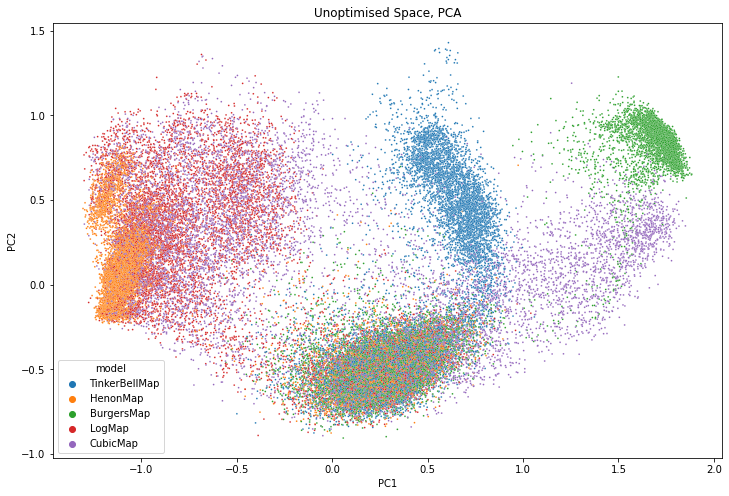

In [18]:
embeddings = space.pcaViz(return_df=True)

In [128]:
len(ts[0][:,0])

31

In [130]:
embeddings

PC1       PC2    N       eta        mu          model
0      0.189775  0.350535   31  0.010685  0.510048  TinkerBellMap
1     -1.184348  0.497791  880  0.082855  0.944604       HenonMap
2      0.402174 -0.477833  450  0.015086  1.474608     BurgersMap
3      0.799796  0.399982  803  0.063672  1.045870  TinkerBellMap
4      0.579237 -0.579663  975  0.011768  1.098539     BurgersMap
...         ...       ...  ...       ...       ...            ...
49995 -0.817275  0.351674  637  0.086683  2.308002       CubicMap
49996 -1.067800  0.238698  873  0.010799  0.377428       HenonMap
49997 -0.455522  0.656232  698  0.020774  3.899671         LogMap
49998  0.218407 -0.448229  592  0.019275  1.146110     BurgersMap
49999  1.195208  0.425695  688  0.071893  2.760444       CubicMap

[50000 rows x 6 columns]

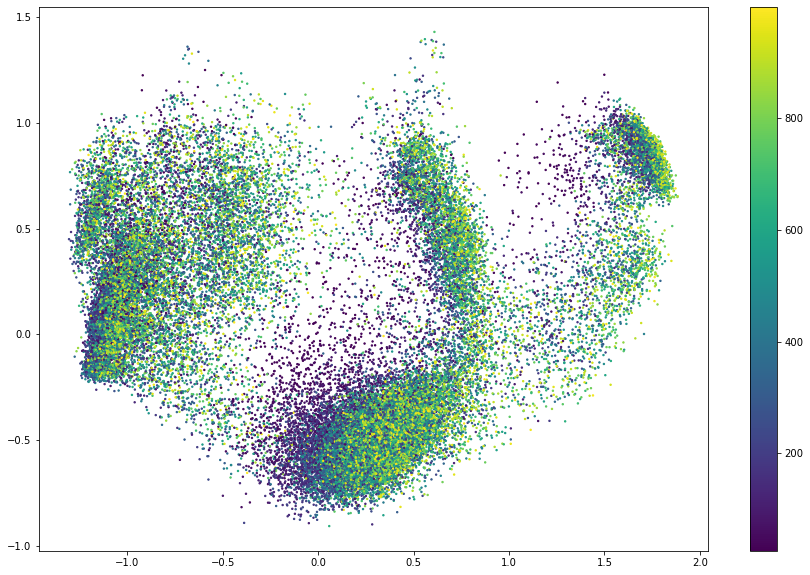

In [136]:
plt.figure(figsize=(15,10))
plt.scatter(embeddings['PC1'], embeddings['PC2'], c=embeddings['N'], s=2)
plt.colorbar()

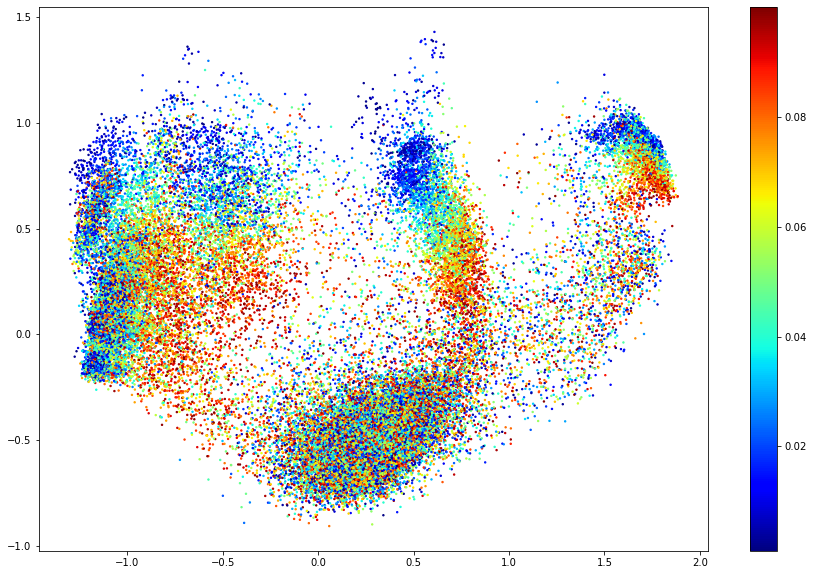

In [139]:
plt.figure(figsize=(15,10))
plt.scatter(embeddings['PC1'], embeddings['PC2'], c=embeddings['eta'], s=2, cmap='jet')
plt.colorbar()

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <a list of 8 Text major ticklabel objects>)

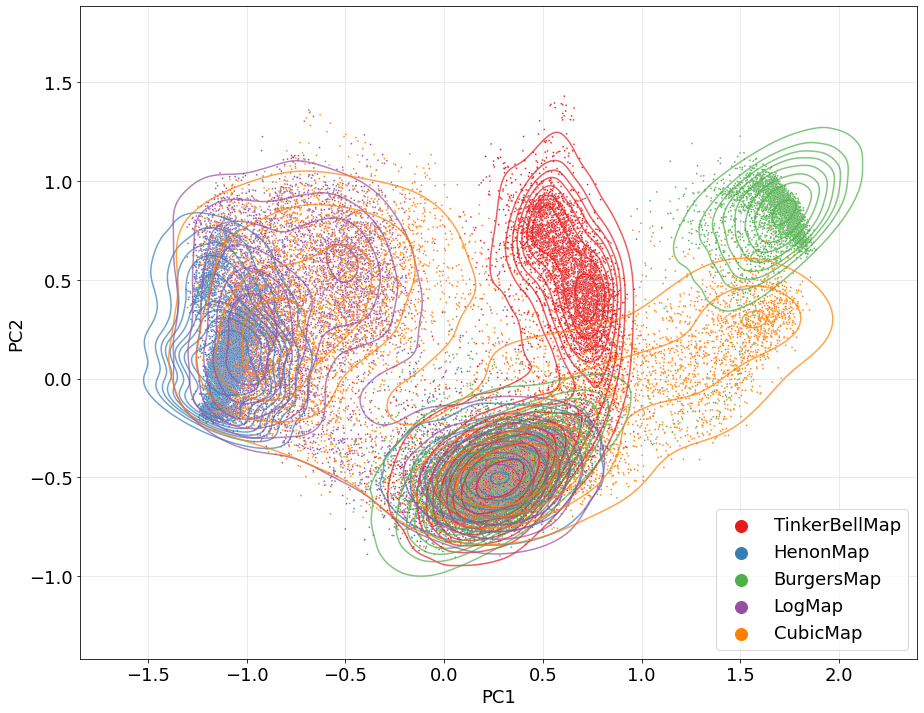

In [526]:
plt.figure(figsize=(15, 12))
plt.grid(alpha=0.3)
sns.kdeplot(data=embeddings, x='PC1', y='PC2', hue='model', palette='Set1', alpha=0.7, levels=10, fill=False)
sns.scatterplot(data=embeddings, x='PC1', y='PC2', hue='model', palette='Set1', s=3)
plt.axis('equal')
plt.legend(fontsize=18, markerscale=2, loc='lower right')
plt.xlabel('PC1', fontsize=18)
plt.ylabel('PC2', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.savefig('discrete_maps_space_appendix.png', dpi=400, bbox_inches='tight', transparent=True)

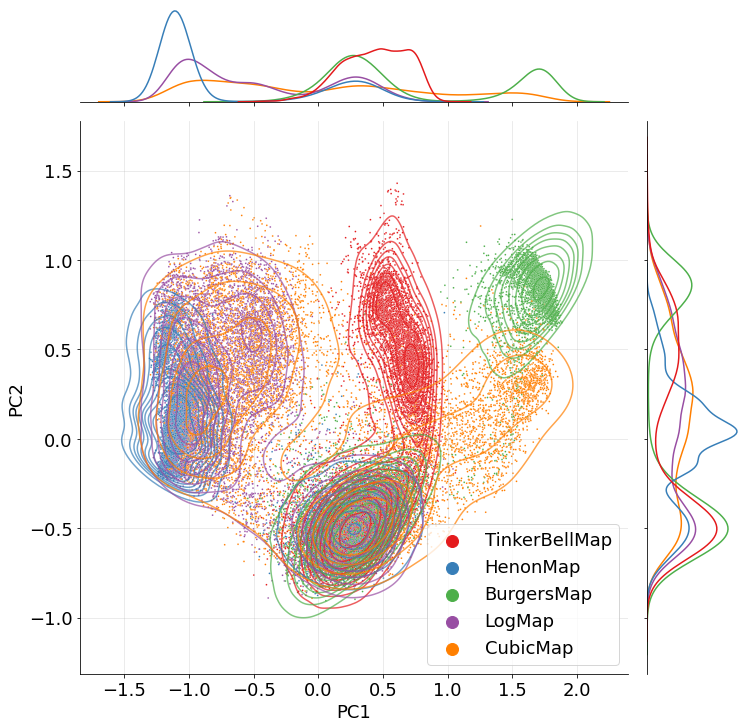

In [330]:
g = sns.jointplot(data=embeddings, x='PC1', y='PC2', hue='model', palette='Set1', alpha=0.7, height=10, kind='kde')
g.plot_joint(sns.scatterplot, s=3, alpha=1)
g.ax_joint.grid(True, alpha=0.3)
handles, labels = g.ax_joint.get_legend_handles_labels() 
g.ax_joint.legend(title="", loc='lower right', fontsize=18, markerscale=2)
g.ax_joint.set_xlabel('PC1', fontsize=18)
g.ax_joint.set_ylabel('PC2', fontsize=18)
g.ax_joint.tick_params(axis='both', which='major', labelsize=18)
g.ax_joint.tick_params(axis='both', which='minor', labelsize=18)
#plt.savefig('jointplot_maps.png', dpi=400, bbox_inches='tight', transparent=True)
plt.show()

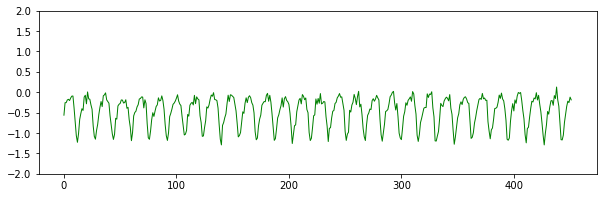

In [322]:
plt.figure(figsize=(10,3))
plt.ylim(-2, 2)
plt.plot(ts[579][:,0], lw=1, c='green')
plt.savefig('burgers_chaotic.svg', transparent=True)

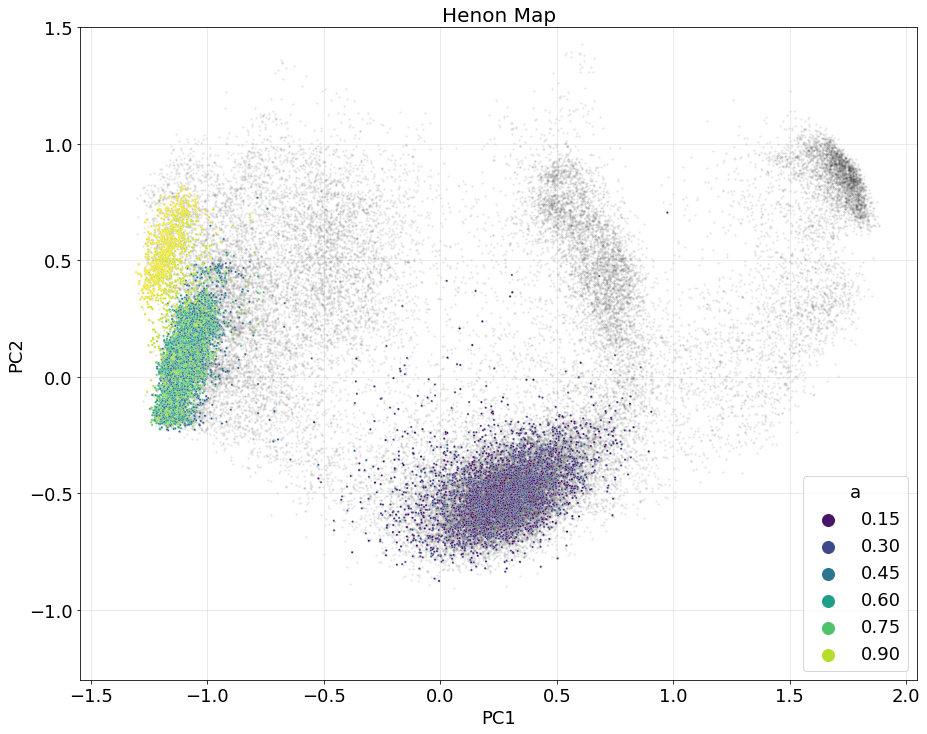

In [376]:
embeddings_model1 = embeddings[embeddings['model'] == 'HenonMap']
plt.figure(figsize=(15, 12))
plt.grid(alpha=0.3)
cmap = plt.cm.get_cmap('viridis')
mu_values = embeddings_model1['mu'].values
mu_norm = (mu_values - np.min(mu_values)) / (np.max(mu_values) - np.min(mu_values))
mu_colors = cmap(mu_norm)

sns.scatterplot(data=embeddings, x='PC1', y='PC2', s=5, color='k', alpha=0.1)
sns.scatterplot(data=embeddings_model1, x='PC1', y='PC2', hue='mu', palette='viridis', s=5)
plt.title('Henon Map', fontsize=20)

plt.axis('equal')
plt.xlabel('PC1', fontsize=18)
plt.ylabel('PC2', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(-2, 2.5)
plt.ylim(-1.3, 1.5)
plt.legend(fontsize=18, markerscale=2, loc='lower right', title='a', title_fontsize=18)
#plt.savefig('henon_map_space.png', dpi=400, bbox_inches='tight', transparent=True)


In [393]:
def find_closest_mu(df, target_map, target_mu, n_closest=5):
    filtered_df = df[df['model'] == target_map]
    
    mu_diffs = np.abs(filtered_df['mu'] - target_mu)
    
    closest_indices = mu_diffs.argsort()[:n_closest]
    return filtered_df.iloc[closest_indices].index

In [541]:
find_closest_mu(embeddings, 'HenonMap', 0.95)

Int64Index([30482, 26587, 19740, 9788, 38193], dtype='int64')

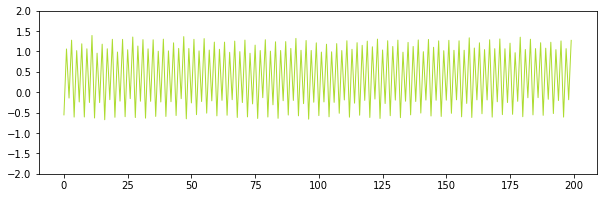

In [545]:
plt.figure(figsize=(10,3))
plt.ylim(-2, 2)
plt.plot(ts[26587][:200,0], lw=1, c='#addc30')
plt.savefig('individual_maps/henon090.svg', transparent=True)

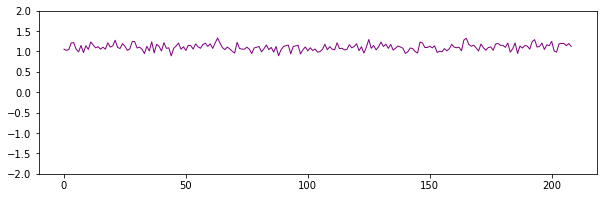

In [368]:
plt.figure(figsize=(10,3))
plt.ylim(-2, 2)
plt.plot(ts[49977][:,0], lw=1, c='purple')

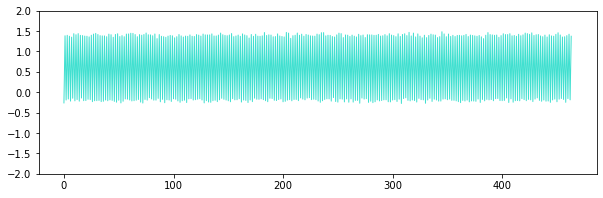

In [369]:
plt.figure(figsize=(10,3))
plt.ylim(-2, 2)
plt.plot(ts[49975][:,0], lw=1, c='turquoise')

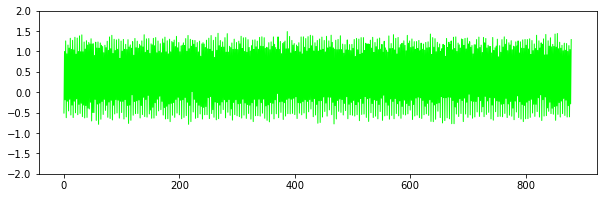

In [370]:
plt.figure(figsize=(10,3))
plt.ylim(-2, 2)
plt.plot(ts[1][:,0], lw=1, c='lime')

In [202]:
def find_nearby_points(df, mu_value, mu_range):
    df['diff'] = abs(df['mu'] - mu_value)
    df_nearby = df[df['diff'] <= mu_range]
    df_nearby = df_nearby.drop(columns=['diff'])
    return df_nearby

In [218]:
out = find_nearby_points(embeddings, 0.9, 0.05)
out[out['model'] == 'HenonMap']

PC1       PC2    N       eta        mu     model      dist
1     -1.184348  0.497791  880  0.082855  0.944604  HenonMap  1.747267
124   -1.012680 -0.010087  247  0.088656  0.891251  HenonMap  1.354391
268   -0.976004  0.204478  632  0.069587  0.870181  HenonMap  1.413993
276   -1.050566  0.030982  573  0.038954  0.893685  HenonMap  1.404782
305   -0.896458  0.412433   26  0.082825  0.910757  HenonMap  1.465230
...         ...       ...  ...       ...       ...       ...       ...
49703 -1.113742  0.133906  672  0.031268  0.897227  HenonMap  1.503871
49712 -1.147834 -0.181526  623  0.028025  0.868667  HenonMap  1.433655
49781 -1.089527 -0.156520  603  0.042268  0.893576  HenonMap  1.382864
49784 -1.073947  0.196014  726  0.032196  0.854070  HenonMap  1.495751
49858 -1.094394  0.112220  680  0.057781  0.879440  HenonMap  1.477230

[1125 rows x 7 columns]

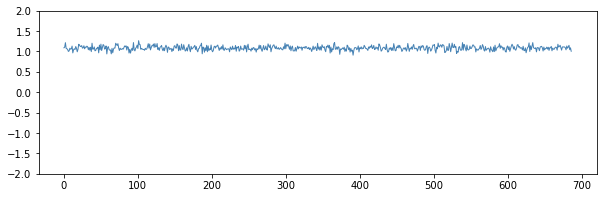

In [217]:
plt.figure(figsize=(10,3))
plt.ylim(-2, 2)
plt.plot(ts[125][:,0], lw=1, c='steelblue')

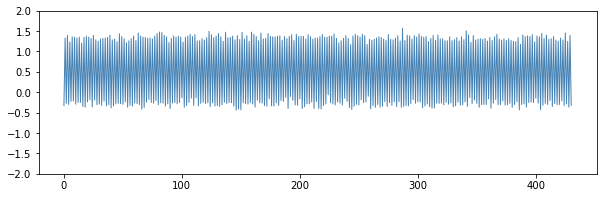

In [342]:
plt.figure(figsize=(10,3))
plt.ylim(-2, 2)
plt.plot(ts[130][:,0], lw=1, c='steelblue')
plt.savefig('henon_chaotic.svg', transparent=True)

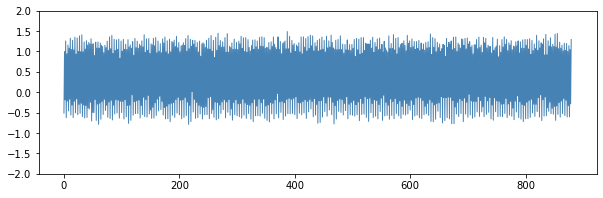

In [229]:
plt.figure(figsize=(10,3))
plt.ylim(-2, 2)
plt.plot(ts[1][:,0], lw=1, c='steelblue')

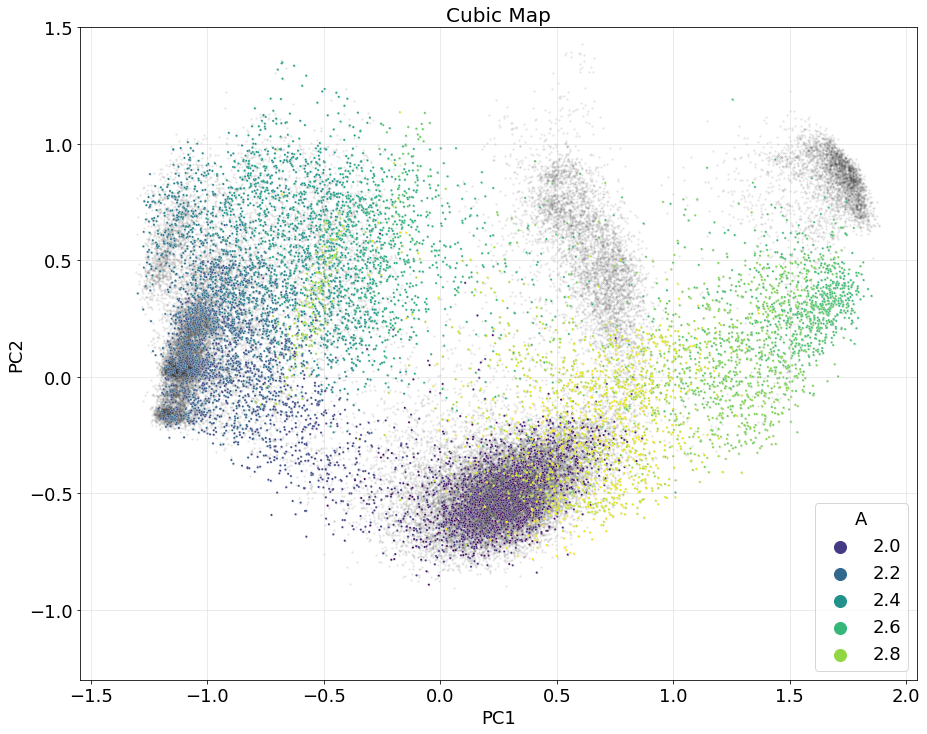

In [374]:
embeddings_model1 = embeddings[embeddings['model'] == 'CubicMap']
plt.figure(figsize=(15, 12))
plt.grid(alpha=0.3)

sns.scatterplot(data=embeddings, x='PC1', y='PC2', s=5, color='k', alpha=0.1)
sns.scatterplot(data=embeddings_model1, x='PC1', y='PC2', hue='mu', palette='viridis', s=5)
plt.title('Cubic Map', fontsize=20)

plt.axis('equal')
plt.xlabel('PC1', fontsize=18)
plt.ylabel('PC2', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(-2, 2.5)
plt.ylim(-1.3, 1.5)
plt.legend(fontsize=18, markerscale=2, loc='lower right', title='A', title_fontsize=18)
plt.savefig('cubic_map_space.png', dpi=400, bbox_inches='tight', transparent=True)

In [938]:
find_closest_mu(embeddings, 'CubicMap', 2.2, 15)

Int64Index([46167, 31913, 29798, 14189, 48937, 47080, 29898,  6255, 17376,
            11685,  6683, 30382,  9984,  4762, 41852],
           dtype='int64')

In [940]:
embeddings.iloc[46167]

PC1     -1.088651
PC2      0.042314
N             329
eta      0.001571
mu       2.200095
model    CubicMap
dist     1.444331
diff     0.700095
Name: 46167, dtype: object

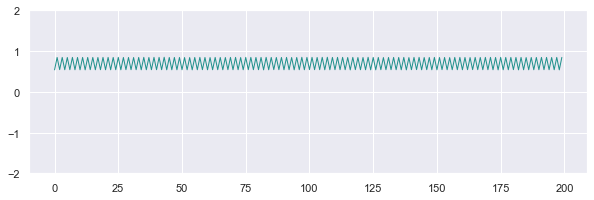

In [941]:
plt.figure(figsize=(10,3))
plt.ylim(-2, 2)
plt.plot(ts[46167][:200,0], lw=1, c='#21918c')
#plt.savefig('individual_maps/cubic24Left.svg', transparent=True)

In [ ]:
plt.figure(figsize=(10,3))
index = 47
plt.ylim(-2, 2)
plt.title(f'PC1:{embeddings.iloc[index]["PC1"]:.2f}, PC2:{embeddings.iloc[index]["PC2"]:.2f}')
plt.plot(ts[index][:,0], lw=1, c='orange')

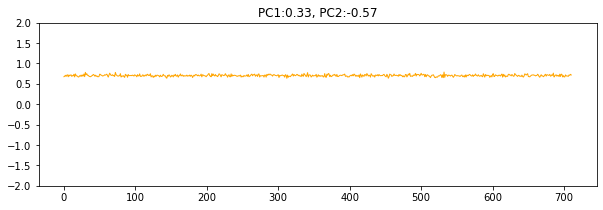

In [247]:
plt.figure(figsize=(10,3))
index = 47
plt.ylim(-2, 2)
plt.title(f'PC1:{embeddings.iloc[index]["PC1"]:.2f}, PC2:{embeddings.iloc[index]["PC2"]:.2f}')
plt.plot(ts[index][:,0], lw=1, c='orange')

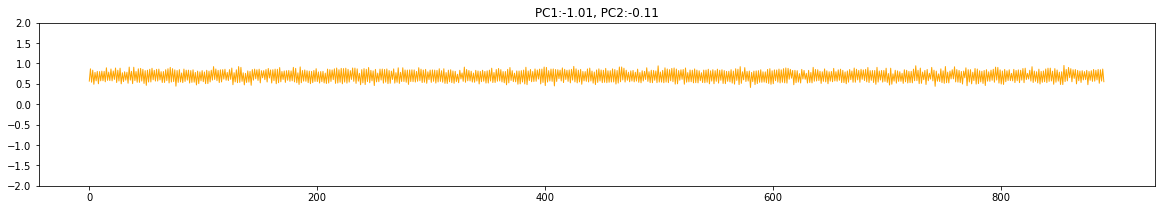

In [343]:
plt.figure(figsize=(20,3))
index = 15
plt.ylim(-2, 2)
plt.title(f'PC1:{embeddings.iloc[index]["PC1"]:.2f}, PC2:{embeddings.iloc[index]["PC2"]:.2f}')
plt.plot(ts[index][:,0], lw=1, c='orange')

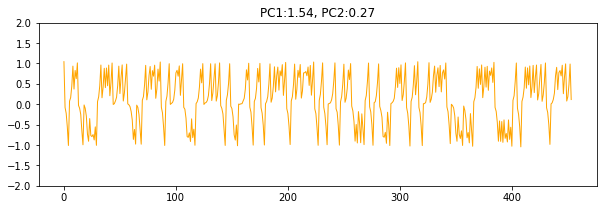

In [341]:
plt.figure(figsize=(10,3))
index = 49961
plt.ylim(-2, 2)
plt.title(f'PC1:{embeddings.iloc[index]["PC1"]:.2f}, PC2:{embeddings.iloc[index]["PC2"]:.2f}')
plt.plot(ts[index][:,0], lw=1, c='orange')
plt.savefig('cubic_chaotic.svg', transparent=True)

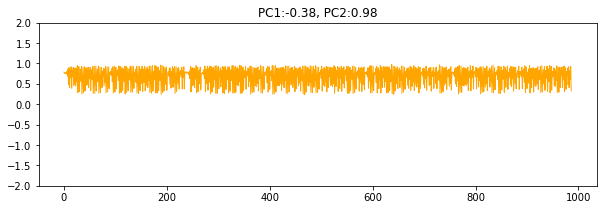

In [250]:
plt.figure(figsize=(10,3))
index = 126
plt.ylim(-2, 2)
plt.title(f'PC1:{embeddings.iloc[index]["PC1"]:.2f}, PC2:{embeddings.iloc[index]["PC2"]:.2f}')
plt.plot(ts[index][:,0], lw=1, c='orange')

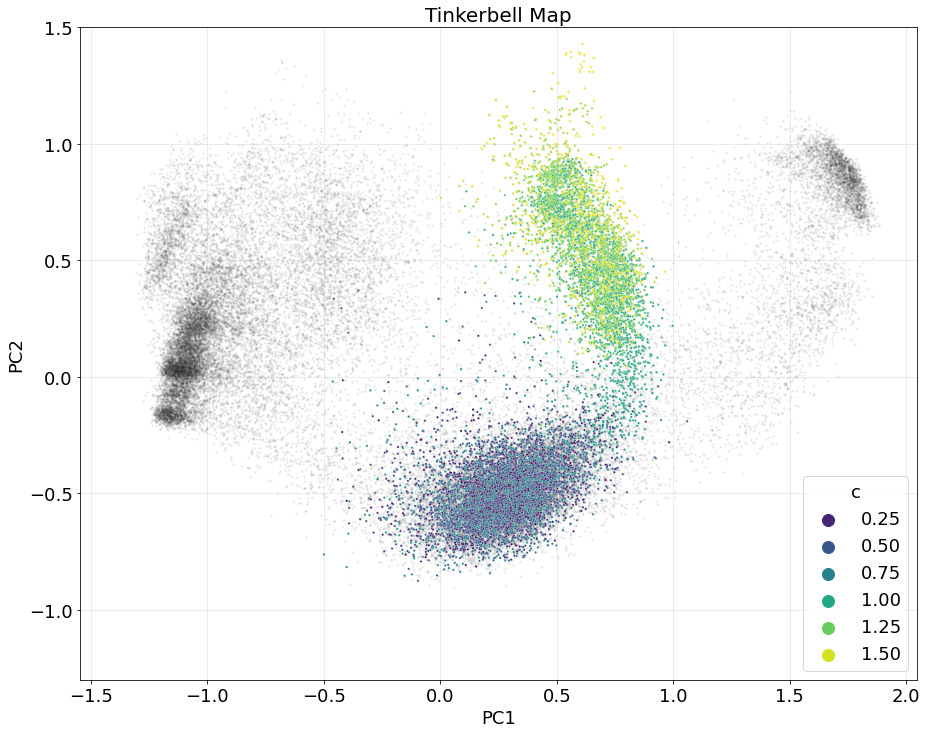

In [389]:
embeddings_model1 = embeddings[embeddings['model'] == 'TinkerBellMap']
plt.figure(figsize=(15, 12))
plt.grid(alpha=0.3)

sns.scatterplot(data=embeddings, x='PC1', y='PC2', s=5, color='k', alpha=0.1)
sns.scatterplot(data=embeddings_model1, x='PC1', y='PC2', hue='mu', palette='viridis', s=5)
plt.title('Tinkerbell Map', fontsize=20)

plt.axis('equal')
plt.xlabel('PC1', fontsize=18)
plt.ylabel('PC2', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(-2, 2.5)
plt.ylim(-1.3, 1.5)
plt.legend(fontsize=18, markerscale=2, loc='lower right', title='c', title_fontsize=18)
plt.savefig('tinkerbell_map_space.png', dpi=400, bbox_inches='tight', transparent=True)

In [606]:
find_closest_mu(embeddings, 'TinkerBellMap', 1.5)

Int64Index([15266, 49494, 22829, 18374, 27301], dtype='int64')

In [611]:
embeddings.iloc[27301]

PC1           0.464801
PC2           0.956016
N                  588
eta           0.035885
mu            1.500389
model    TinkerBellMap
dist          1.471775
diff          0.000389
Name: 27301, dtype: object

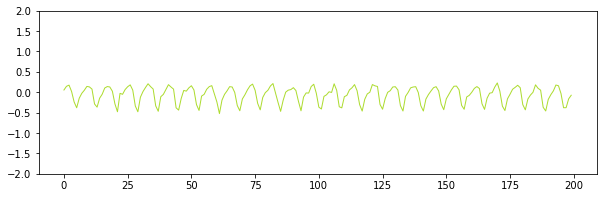

In [613]:
plt.figure(figsize=(10,3))
plt.ylim(-2, 2)
plt.plot(ts[27301][:200,0], lw=1, c='#addc30')
plt.savefig('individual_maps/tinkerbell150.svg', transparent=True)

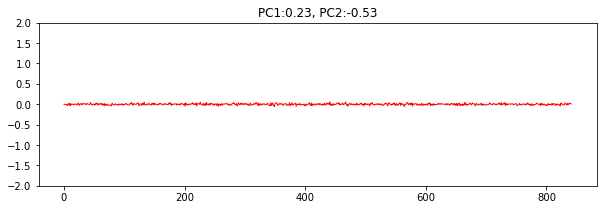

In [254]:
plt.figure(figsize=(10,3))
index = 230
plt.ylim(-2, 2)
plt.title(f'PC1:{embeddings.iloc[index]["PC1"]:.2f}, PC2:{embeddings.iloc[index]["PC2"]:.2f}')
plt.plot(ts[index][:,0], lw=1, c='red')

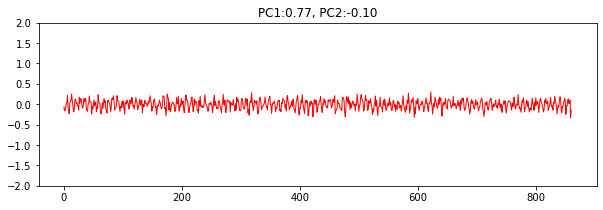

In [258]:
plt.figure(figsize=(10,3))
index = 10
plt.ylim(-2, 2)
plt.title(f'PC1:{embeddings.iloc[index]["PC1"]:.2f}, PC2:{embeddings.iloc[index]["PC2"]:.2f}')
plt.plot(ts[index][:,0], lw=1, c='red')

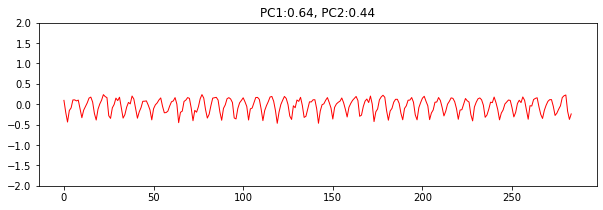

In [336]:
plt.figure(figsize=(10,3))
index = 290
plt.ylim(-2, 2)
plt.title(f'PC1:{embeddings.iloc[index]["PC1"]:.2f}, PC2:{embeddings.iloc[index]["PC2"]:.2f}')
plt.plot(ts[index][:,0], lw=1, c='red')
plt.savefig('tinkerbell_chaotic.svg', transparent=True)

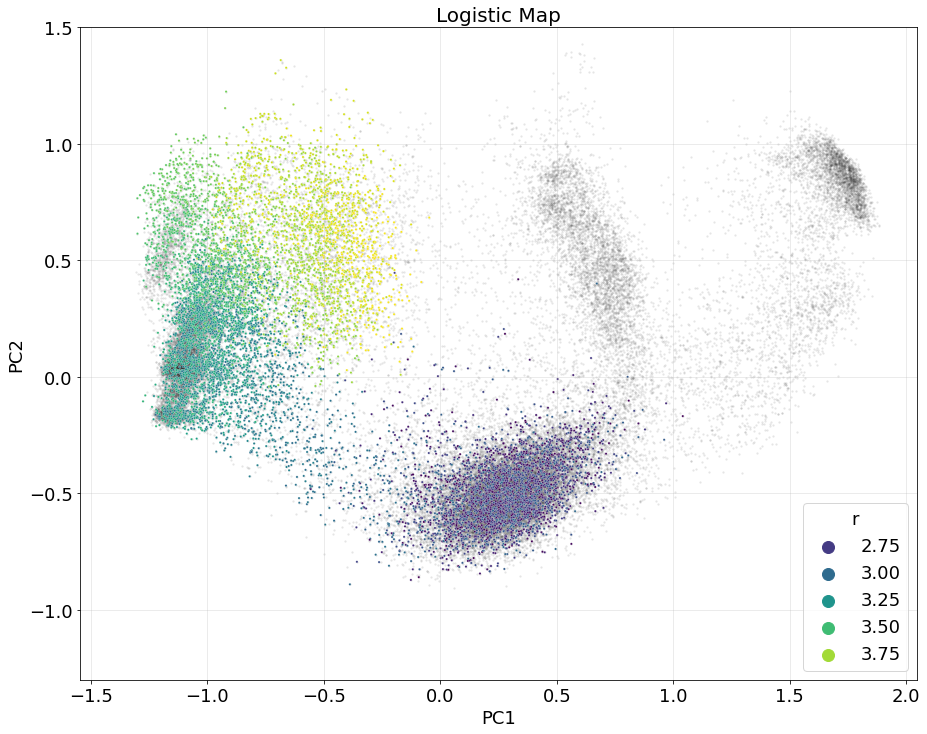

In [390]:
embeddings_model1 = embeddings[embeddings['model'] == 'LogMap']
plt.figure(figsize=(15, 12))
plt.grid(alpha=0.3)

sns.scatterplot(data=embeddings, x='PC1', y='PC2', s=5, color='k', alpha=0.1)
sns.scatterplot(data=embeddings_model1, x='PC1', y='PC2', hue='mu', palette='viridis', s=5)
plt.title('Logistic Map', fontsize=20)

plt.axis('equal')
plt.xlabel('PC1', fontsize=18)
plt.ylabel('PC2', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(-2, 2.5)
plt.ylim(-1.3, 1.5)
plt.legend(fontsize=18, markerscale=2, loc='lower right', title='r', title_fontsize=18)
plt.savefig('logistic_map_space.png', dpi=400, bbox_inches='tight', transparent=True)

In [624]:
find_closest_mu(embeddings, 'LogMap', 3.25)

Int64Index([10263, 23999, 27128, 42370, 9975], dtype='int64')

In [625]:
embeddings.iloc[23999]

PC1      -1.05277
PC2     -0.115245
N             932
eta      0.024501
mu       3.250388
model      LogMap
dist     1.358398
diff     1.750388
Name: 23999, dtype: object

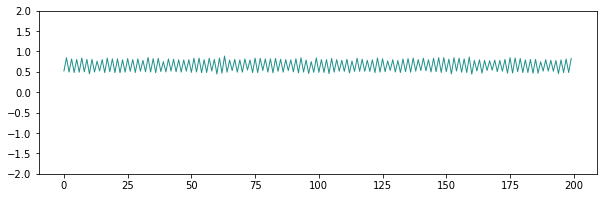

In [627]:
plt.figure(figsize=(10,3))
plt.ylim(-2, 2)
plt.plot(ts[23999][:200,0], lw=1, c='#21918c')
plt.savefig('individual_maps/logmap325.svg', transparent=True)

In [273]:
out = find_nearby_points(embeddings, 3.75, 0.05)
out[out['model'] == 'LogMap']

PC1       PC2    N       eta        mu   model      dist
14    -0.503495  0.471711  737  0.055489  3.702194  LogMap  1.229625
206   -0.538525  0.164171  918  0.085602  3.719382  LogMap  1.030968
284   -0.696837  0.767848   51  0.012149  3.725146  LogMap  1.582384
304   -0.561800  0.981830   25  0.018809  3.748122  LogMap  1.689627
331   -0.556305  0.915274  298  0.013393  3.711541  LogMap  1.628843
...         ...       ...  ...       ...       ...     ...       ...
49750 -0.350353  0.755881  603  0.027133  3.792468  LogMap  1.391999
49789 -0.578278  0.162098  489  0.082890  3.707340  LogMap  1.060386
49913 -0.507306  0.733778  510  0.035585  3.791516  LogMap  1.447661
49974 -0.669323  0.649025   54  0.066157  3.737644  LogMap  1.471535
49992 -0.500579  0.207635  800  0.069510  3.729725  LogMap  1.031560

[693 rows x 7 columns]

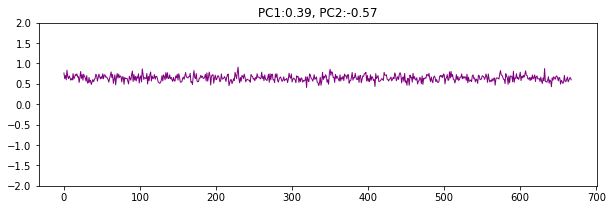

In [338]:
plt.figure(figsize=(10,3))
index = 42
plt.ylim(-2, 2)
plt.title(f'PC1:{embeddings.iloc[index]["PC1"]:.2f}, PC2:{embeddings.iloc[index]["PC2"]:.2f}')
plt.plot(ts[index][:,0], lw=1, c='purple')
plt.savefig('log_fp.svg', transparent=True)

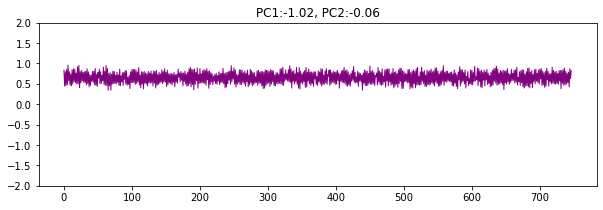

In [271]:
plt.figure(figsize=(10,3))
index = 148
plt.ylim(-2, 2)
plt.title(f'PC1:{embeddings.iloc[index]["PC1"]:.2f}, PC2:{embeddings.iloc[index]["PC2"]:.2f}')
plt.plot(ts[index][:,0], lw=1, c='purple')

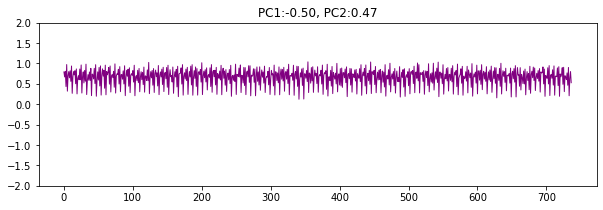

In [340]:
plt.figure(figsize=(10,3))
index = 14
plt.ylim(-2, 2)
plt.title(f'PC1:{embeddings.iloc[index]["PC1"]:.2f}, PC2:{embeddings.iloc[index]["PC2"]:.2f}')
plt.plot(ts[index][:,0], lw=1, c='purple')
plt.savefig('log_chaotic.svg', transparent=True)

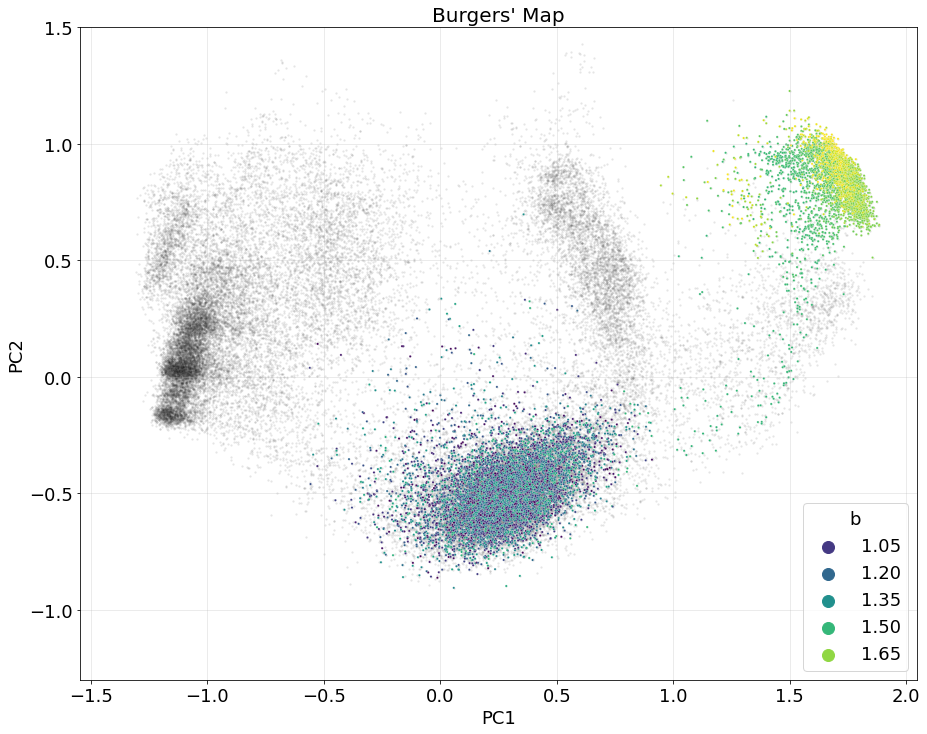

In [391]:
embeddings_model1 = embeddings[embeddings['model'] == 'BurgersMap']
plt.figure(figsize=(15, 12))
plt.grid(alpha=0.3)

sns.scatterplot(data=embeddings, x='PC1', y='PC2', s=5, color='k', alpha=0.1)
sns.scatterplot(data=embeddings_model1, x='PC1', y='PC2', hue='mu', palette='viridis', s=5)
plt.title("Burgers' Map", fontsize=20)

plt.axis('equal')
plt.xlabel('PC1', fontsize=18)
plt.ylabel('PC2', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(-2, 2.5)
plt.ylim(-1.3, 1.5)
plt.legend(fontsize=18, markerscale=2, loc='lower right', title='b', title_fontsize=18)
plt.savefig('burgers_map_space.png', dpi=400, bbox_inches='tight', transparent=True)

In [635]:
find_closest_mu(embeddings, 'BurgersMap', 1.05)

Int64Index([33028, 34835, 6967, 328, 27573], dtype='int64')

In [636]:
embeddings.iloc[34835]

PC1        0.360597
PC2         -0.2382
N               173
eta        0.023671
mu         1.049996
model    BurgersMap
dist       0.284202
diff       0.450004
Name: 34835, dtype: object

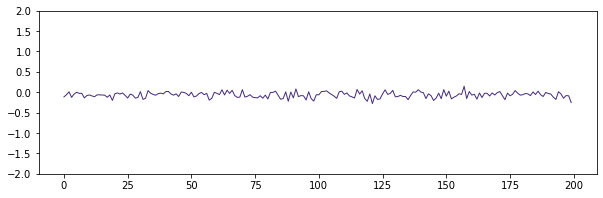

In [640]:
plt.figure(figsize=(10,3))
plt.ylim(-2, 2)
plt.plot(ts[33028][:200,0], lw=1, c='#472d7b')
plt.savefig('individual_maps/burgersmap105.svg', transparent=True)

In [392]:
embeddings

PC1       PC2    N       eta        mu          model      dist  \
0      0.189775  0.350535   31  0.010685  0.510048  TinkerBellMap  0.852665   
1     -1.184348  0.497791  880  0.082855  0.944604       HenonMap  1.747267   
2      0.402174 -0.477833  450  0.015086  1.474608     BurgersMap  0.153780   
3      0.799796  0.399982  803  0.063672  1.045870  TinkerBellMap  1.054630   
4      0.579237 -0.579663  975  0.011768  1.098539     BurgersMap  0.338737   
...         ...       ...  ...       ...       ...            ...       ...   
49995 -0.817275  0.351674  637  0.086683  2.308002       CubicMap  1.365439   
49996 -1.067800  0.238698  873  0.010799  0.377428       HenonMap  1.510718   
49997 -0.455522  0.656232  698  0.020774  3.899671         LogMap  1.354487   
49998  0.218407 -0.448229  592  0.019275  1.146110     BurgersMap  0.060650   
49999  1.195208  0.425695  688  0.071893  2.760444       CubicMap  1.323000   

           diff  
0      0.989952  
1      0.555396  
2      0.025392  
3      0.454130  
4      0.401461  
...         ...  
49995  0.808002  
49996  1.122572  
49997  2.399671  
49998  0.353890  
49999  1.260444  

[50000 rows x 8 columns]

In [278]:
out = find_nearby_points(embeddings, 1.5, 0.05)
out[out['model'] == 'BurgersMap']

PC1       PC2    N       eta        mu       model      dist
2      0.402174 -0.477833  450  0.015086  1.474608  BurgersMap  0.153780
16     1.505897  0.107180  458  0.078532  1.503862  BurgersMap  1.394972
67    -0.217367 -0.360440   54  0.022713  1.479515  BurgersMap  0.487759
83     1.515655 -0.009104  436  0.020726  1.496367  BurgersMap  1.357520
101    1.422854  0.796786  263  0.033529  1.513778  BurgersMap  1.748497
...         ...       ...  ...       ...       ...         ...       ...
49588  1.541103  0.877095  260  0.015320  1.530689  BurgersMap  1.887680
49643  1.503573  0.926955  635  0.025993  1.527378  BurgersMap  1.899380
49719  1.567107  0.665704  486  0.070810  1.528887  BurgersMap  1.758873
49779  1.471733  0.429472  496  0.085212  1.534626  BurgersMap  1.535106
49798  1.513413  0.438924  614  0.082793  1.537611  BurgersMap  1.574100

[1067 rows x 7 columns]

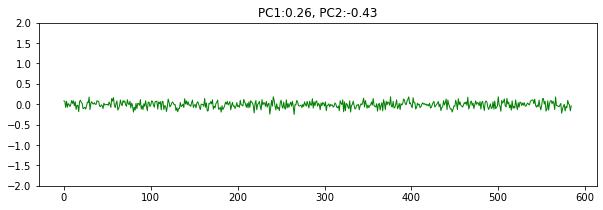

In [339]:
plt.figure(figsize=(10,3))
index = 49957
plt.ylim(-2, 2)
plt.title(f'PC1:{embeddings.iloc[index]["PC1"]:.2f}, PC2:{embeddings.iloc[index]["PC2"]:.2f}')
plt.plot(ts[index][:,0], lw=1, c='green')
plt.savefig('burgers_fp.svg', transparent=True)

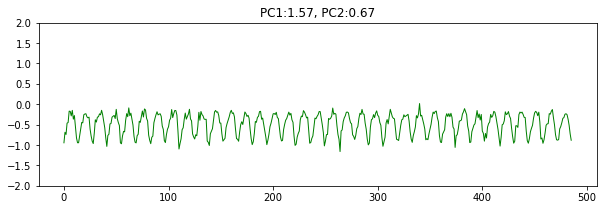

In [279]:
plt.figure(figsize=(10,3))
index = 49719
plt.ylim(-2, 2)
plt.title(f'PC1:{embeddings.iloc[index]["PC1"]:.2f}, PC2:{embeddings.iloc[index]["PC2"]:.2f}')
plt.plot(ts[index][:,0], lw=1, c='green')

create evaluation data for epsilon (our approach) and lambda (SINDy) optimisation

In [19]:
df_eval, ts_eval = sample_maps2(2, seed=21)

iteration: 0
Optimal Epsilon (LogLoss): 1.2


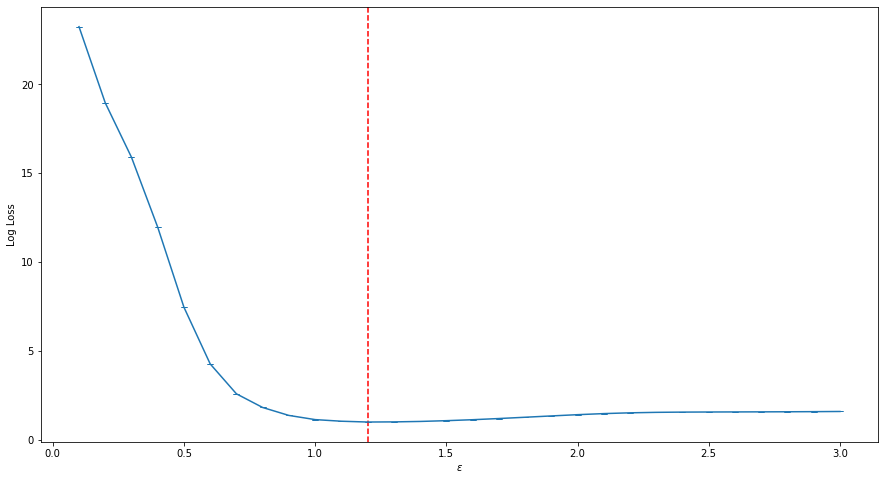

In [20]:
radii, meta_logloss = evaluate_space(space, df_eval, ts_eval)

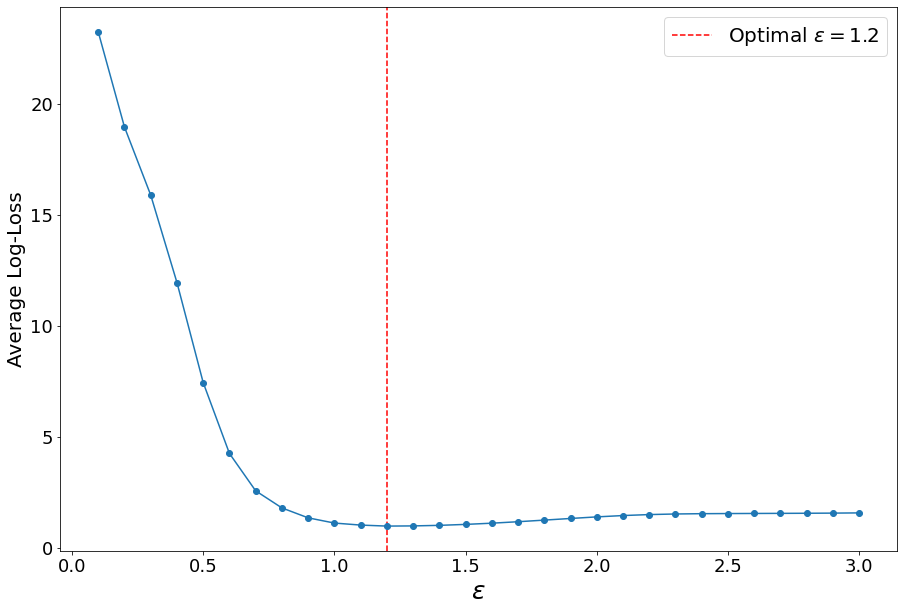

In [21]:
plt.figure(figsize=(15, 10))
plt.axvline(x=1.2, color='r', linestyle='--', label='Optimal $\epsilon = 1.2$')
plt.legend(fontsize=20)
plt.plot(radii, meta_logloss[0], marker='o')
plt.xlabel('$\epsilon$', fontsize=25)
plt.ylabel('Average Log-Loss', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('instance_space_maps_logloss.svg')


In [22]:
space.setEpsilon(1.2)

#### Optimise SINDy $\lambda$ for constrained and unconstrained libraries

We will allow SINDy to have access to all of the 'training data' for the calibration and optimisation of our method

In [23]:
fourier_library = ps.FourierLibrary(n_frequencies=1)
polynomial_library = ps.PolynomialLibrary(degree=5)
custom_funcs = [lambda x: np.exp(x), lambda x: np.exp(-x)]
custom_funcs_names = [lambda x: 'exp(' + x +')', lambda x: 'exp(-' + x + ')']
custom_lib = ps.CustomLibrary(library_functions=custom_funcs, function_names=custom_funcs_names)
unconstrained_lib = ps.GeneralizedLibrary([polynomial_library, fourier_library, custom_lib])
constrained_lib = ps.PolynomialLibrary(degree=4)

Unconstrained library optimal $\lambda$

In [24]:
ts_opt_sindy = ts_eval

Here, we give SINDy access to the same data as we use for calibrating our method, including the training and evaluation set.

In [25]:
lambdas = np.linspace(0.05, 0.4, 50)

# Initialize a dictionary to store the results
map_names = ['LogMap', 'CubicMap', 'TinkerBellMap', 'HenonMap', 'BurgersMap']
results_uncon = {name: [] for name in map_names}
total_identifications_uncon = []

for lamb in lambdas:
    model = ps.SINDy(feature_library=unconstrained_lib, feature_names=['x', 'y', 'mu'], discrete_time=True, optimizer=ps.STLSQ(threshold=lamb))
    num_log = 0
    num_cubic = 0
    num_tinkerBell = 0
    num_henon = 0
    num_burgers = 0

    for i in range(len(ts_opt_sindy)):
        log_ts = ts_opt_sindy[i][0]
        cubic_ts = ts_opt_sindy[i][1]
        tinkerBell_ts = ts_opt_sindy[i][2]
        henon_ts = ts_opt_sindy[i][3]
        burgers_ts = ts_opt_sindy[i][4]

        if isLogMap_sindy(log_ts, model):
            num_log += 1
        if isCubicMap_sindy(cubic_ts, model):
            num_cubic += 1
        if isTinkerBellMap_sindy(tinkerBell_ts, model):
            num_tinkerBell += 1
        if isHenonMap_sindy(henon_ts, model):
            num_henon += 1
        if isBurgersMap_sindy(burgers_ts, model):
            num_burgers += 1

    # add counts of identifications for each map to the results dictionary
    results_uncon['LogMap'].append(num_log)
    results_uncon['CubicMap'].append(num_cubic)
    results_uncon['TinkerBellMap'].append(num_tinkerBell)
    results_uncon['HenonMap'].append(num_henon)
    results_uncon['BurgersMap'].append(num_burgers)

    # calc the total identifications for this lambda value and append it to the total_identifications list
    total_identifications_uncon.append(num_log + num_cubic + num_tinkerBell + num_henon + num_burgers)

# print the results
print("Results:", results_uncon)
print("Total identifications:", total_identifications_uncon)



Results: {'LogMap': [31, 35, 71, 81, 85, 80, 68, 55, 38, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'CubicMap': [1, 10, 19, 28, 42, 54, 93, 114, 115, 110, 106, 101, 91, 79, 67, 58, 49, 45, 41, 32, 24, 18, 10, 8, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'TinkerBellMap': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'HenonMap': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'BurgersMap': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Total identifications: [32, 45, 90, 109, 127, 134, 161, 169, 153, 134, 106, 101, 91, 79, 67, 58, 49, 45, 41, 32, 24, 18, 10, 8, 

In [688]:
results_uncon.items()

dict_items([('LogMap', [31, 35, 71, 81, 85, 80, 68, 55, 38, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ('CubicMap', [1, 10, 19, 28, 42, 54, 93, 114, 115, 110, 106, 101, 91, 79, 67, 58, 49, 45, 41, 32, 24, 18, 10, 8, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ('TinkerBellMap', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ('HenonMap', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ('BurgersMap', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])])

In [26]:
best_lambda_idx_uncon = np.argmax(total_identifications_uncon)
best_lambda_uncon = lambdas[best_lambda_idx_uncon]
print(f'Best lambda: {best_lambda_uncon}')

Best lambda: 0.1


(0.0, 1.0)

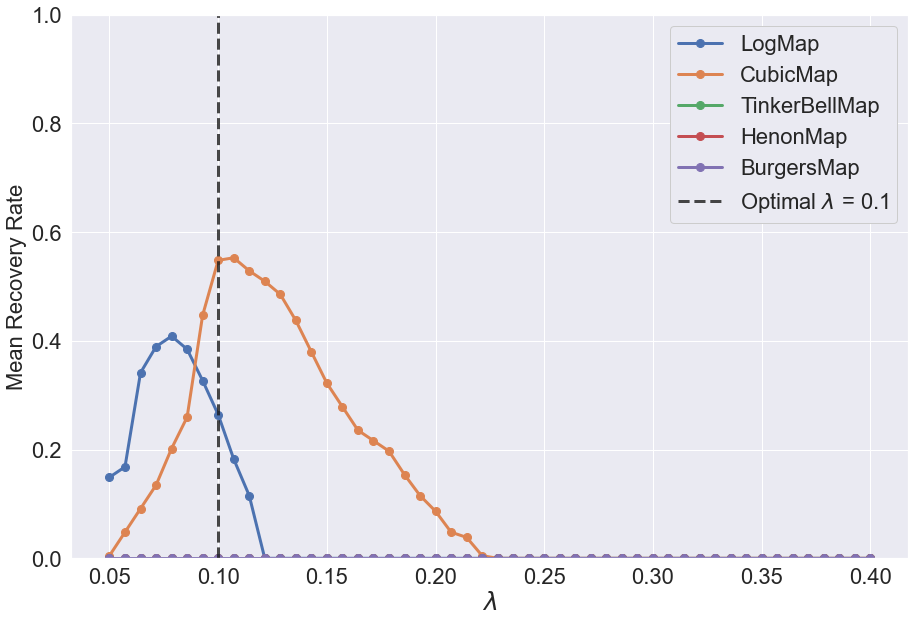

In [740]:
plt.figure(figsize=(15, 10))
sns.set_theme(style="darkgrid")
for map_name, num_list in results_uncon.items():
    num_list = np.array(num_list)/len(ts_opt_sindy) # convert to fraction
    plt.plot(lambdas, num_list, label=map_name, marker='o', lw=3, ms=8)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('$\lambda$', fontsize=25)
plt.axvline(x=best_lambda_uncon, color='k', linestyle='--', label=f'Optimal $\lambda$ = {best_lambda_uncon}', alpha=0.8, lw=3)
plt.ylabel('Mean Recovery Rate', fontsize=22)
plt.legend(fontsize=22, loc='upper right', framealpha=1)
plt.ylim(0, 1)
#plt.savefig('sindy_unconstrained_lambda.svg')

----------

Repeat optimisation for constrained library

In [29]:
lambdas = np.linspace(0.05, 0.4, 50)

# Initialize a dictionary to store the results
map_names = ['LogMap', 'CubicMap', 'TinkerBellMap', 'HenonMap', 'BurgersMap']
results = {name: [] for name in map_names}
total_identifications = []

for lamb in lambdas:
    model = ps.SINDy(feature_library=constrained_lib, feature_names=['x', 'y', 'mu'], discrete_time=True, optimizer=ps.STLSQ(threshold=lamb))
    num_log = 0
    num_cubic = 0
    num_tinkerBell = 0
    num_henon = 0
    num_burgers = 0

    for i in range(len(ts_opt_sindy)):
        log_ts = ts_opt_sindy[i][0]
        cubic_ts = ts_opt_sindy[i][1]
        tinkerBell_ts = ts_opt_sindy[i][2]
        henon_ts = ts_opt_sindy[i][3]
        burgers_ts = ts_opt_sindy[i][4]

        if isLogMap_sindy(log_ts, model):
            num_log += 1
        if isCubicMap_sindy(cubic_ts, model):
            num_cubic += 1
        if isTinkerBellMap_sindy(tinkerBell_ts, model):
            num_tinkerBell += 1
        if isHenonMap_sindy(henon_ts, model):
            num_henon += 1
        if isBurgersMap_sindy(burgers_ts, model):
            num_burgers += 1

    # add the counts of identifications for each map to the results dictionary
    results['LogMap'].append(num_log)
    results['CubicMap'].append(num_cubic)
    results['TinkerBellMap'].append(num_tinkerBell)
    results['HenonMap'].append(num_henon)
    results['BurgersMap'].append(num_burgers)

    # calculate the total identifications for this lambda value and append it to the total_identifications list
    total_identifications.append(num_log + num_cubic + num_tinkerBell + num_henon + num_burgers)


print("Results:", results)
print("Total identifications:", total_identifications)

Results: {'LogMap': [29, 57, 84, 107, 114, 115, 115, 117, 107, 98, 90, 80, 74, 65, 57, 53, 51, 48, 46, 41, 37, 36, 35, 35, 32, 29, 27, 23, 22, 19, 16, 15, 15, 11, 8, 7, 7, 6, 6, 4, 3, 3, 2, 1, 0, 0, 0, 0, 0, 0], 'CubicMap': [96, 111, 117, 120, 124, 125, 130, 135, 142, 146, 147, 147, 150, 149, 151, 153, 153, 155, 155, 155, 155, 155, 155, 156, 156, 157, 157, 156, 156, 155, 155, 156, 156, 156, 156, 156, 153, 151, 149, 148, 144, 141, 137, 130, 108, 77, 64, 50, 36, 29], 'TinkerBellMap': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 7, 9, 10, 10, 8, 9, 14, 15, 14, 14, 13, 14, 13, 12, 11, 10, 9, 7, 4], 'HenonMap': [3, 5, 30, 59, 75, 89, 104, 111, 115, 118, 120, 122, 123, 128, 129, 130, 129, 129, 130, 131, 131, 126, 101, 76, 49, 28, 17, 6, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'BurgersMap': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 13, 27, 34, 33, 35, 35, 30, 31, 31, 29, 25, 23, 21, 18, 15, 12, 9, 8

In [30]:
best_lambda_idx = np.argmax(total_identifications)
best_lambda = lambdas[best_lambda_idx]
print(f'Best lambda: {best_lambda}')

Best lambda: 0.10714285714285715


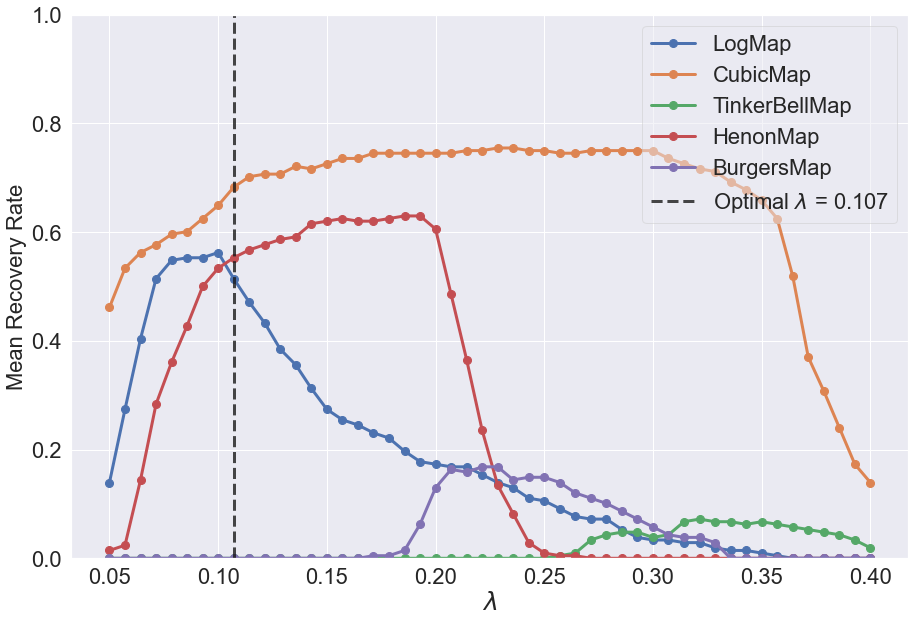

In [737]:
plt.figure(figsize=(15, 10))
#plt.axvline(x=best_lambda, color='k', linestyle='--', label='Best $\lambda$')
for map_name, num_list in results.items():
    num_list = np.array(num_list)/len(ts_opt_sindy) # convert to fraction
    plt.plot(lambdas, num_list, label=map_name, marker='o', lw=3, ms=8)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('$\lambda$', fontsize=25)
plt.axvline(x=best_lambda, color='k', linestyle='--', label=f'Optimal $\lambda$ = {best_lambda:.3f}', alpha=0.8, lw=3)
plt.ylabel('Mean Recovery Rate', fontsize=22)
plt.legend(fontsize=22, loc='upper right', framealpha=0.5)
plt.ylim(0, 1)
plt.savefig('sindy_constrained_lambda.svg')

## Optimal values summary

- Optimal $\epsilon$ for instance space: 1.142
- Optimal $\lambda$ for unconstrained sindy: 0.1
- Optimal $\lambda$ for constrained sindy: 0.107

----------

## Logistic Map Identification

In [32]:
Ns = [25, 50, 75, 100, 125, 150, 175, 200, 300, 400, 500, 800, 1000]  # time series lengths
etas = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.02, 0.05, 0.1]  # list of eta values
optimal_lambda_uncon = 0.1
optimal_lambda_con = 0.107
model1 = ps.SINDy(feature_library=unconstrained_lib, feature_names=['x', 'mu'], discrete_time=True, optimizer=ps.STLSQ(threshold=optimal_lambda_uncon))
model2 = ps.SINDy(feature_library=constrained_lib, feature_names=['x', 'mu'], discrete_time=True, optimizer=ps.STLSQ(threshold=optimal_lambda_con))
n_iter = 100
results_log_sindy_uncon = dict()
results_log_sindy_con = dict()
results_log_isa = dict()

for eta in etas:
    n_identifications_sindy_uncon = list()
    n_identifications_sindy_con = list()
    n_identifications_isa = list()
    for n in Ns:
        identifications_sindy_uncon = list()
        identifications_sindy_con = list()
        identifications_isa = list()
        for i in range(n_iter):
            df_test, ts_test = generate_LogMap(n, eta)
            identifications_sindy_uncon.append(isLogMap_sindy(ts_test, model1, tol=0.1))
            identifications_sindy_con.append(isLogMap_sindy(ts_test, model2, tol=0.1))
            identifications_isa.append(isMap_isa(space, 'LogMap', df_test, ts_test))
        non_zero_sindy_uncon = np.count_nonzero(identifications_sindy_uncon)
        non_zero_sindy_con = np.count_nonzero(identifications_sindy_con)
        non_zero_isa = np.count_nonzero(identifications_isa)
        n_identifications_sindy_uncon.append(non_zero_sindy_uncon)
        n_identifications_sindy_con.append(non_zero_sindy_con)
        n_identifications_isa.append(non_zero_isa)
    fraction_identified_sindy_uncon = np.array(n_identifications_sindy_uncon) / n_iter
    fraction_identified_sindy_con = np.array(n_identifications_sindy_con) / n_iter
    fraction_identified_isa = np.array(n_identifications_isa) / n_iter
    results_log_sindy_uncon[eta] = fraction_identified_sindy_uncon
    results_log_sindy_con[eta] = fraction_identified_sindy_con
    results_log_isa[eta] = fraction_identified_isa

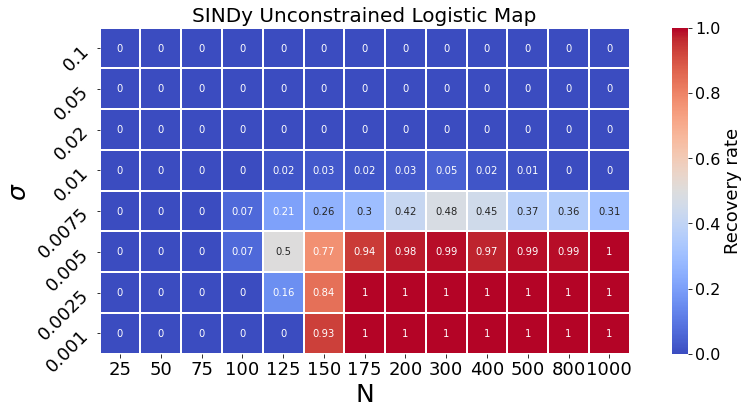

In [344]:
heatmap_data = np.array([results_log_sindy_uncon[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Recovery rate', fontsize=18)
plt.title('SINDy Unconstrained Logistic Map', fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

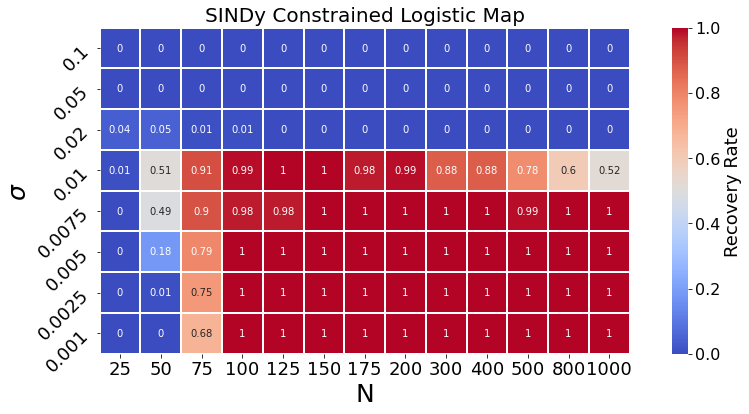

In [34]:
heatmap_data = np.array([results_log_sindy_con[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Recovery Rate', fontsize=18)
plt.title('SINDy Constrained Logistic Map', fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

our method

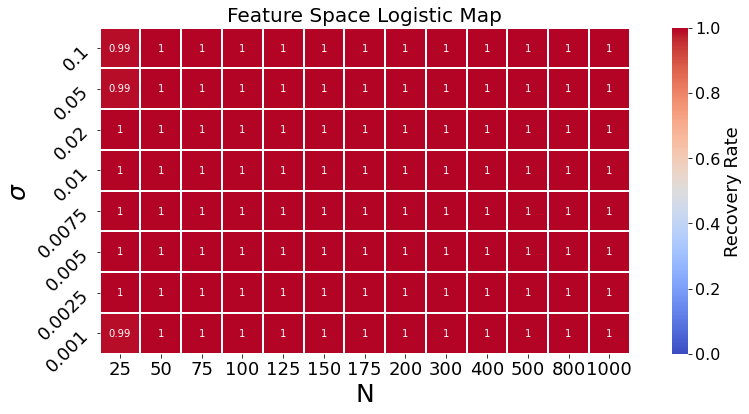

In [35]:
heatmap_data = np.array([results_log_isa[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
plt.title('Feature Space Logistic Map', fontsize=20)
cbar.ax.set_ylabel('Recovery Rate', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

### Compute the difference in recovery rates

In [36]:
import matplotlib.colors as mcolors

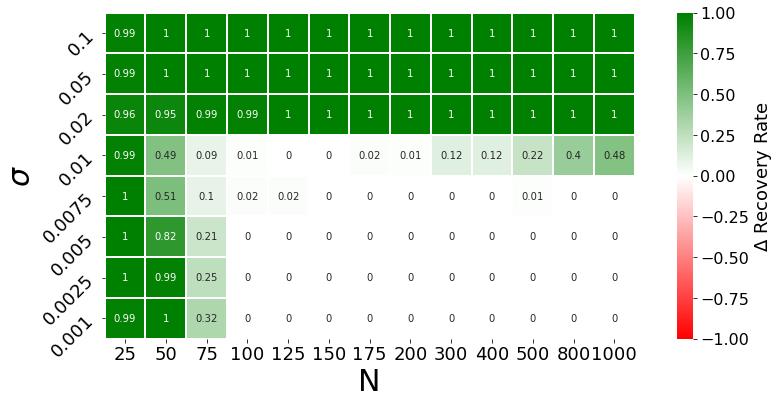

In [37]:
results_method1 = np.array([results_log_sindy_con[eta] for eta in etas])
results_method2 = np.array([results_log_isa[eta] for eta in etas])

# compute the difference
performance_difference = results_method2 - results_method1

colors = ['red', 'white', 'green']
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# display as a single heatmap
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(performance_difference, annot=True, cmap=cmap, xticklabels=Ns, yticklabels=etas, cbar_kws={'label': '$\Delta$ Recovery Rate'}, linewidth=1, linecolor='w', square=True, vmin=-1, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('$\Delta$ Recovery Rate', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=30)
plt.ylabel('$\sigma$', fontsize=30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

--------

## Cubic Map Identification

In [38]:
Ns = [25, 50, 75, 100, 125, 150, 175, 200, 300, 400, 500, 800, 1000]  # time series lengths
etas = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.02, 0.05, 0.1]  # list of eta values
optimal_lambda_uncon = 0.1
optimal_lambda_con = 0.107
model1 = ps.SINDy(feature_library=unconstrained_lib, feature_names=['x', 'mu'], discrete_time=True, optimizer=ps.STLSQ(threshold=optimal_lambda_uncon))
model2 = ps.SINDy(feature_library=constrained_lib, feature_names=['x', 'mu'], discrete_time=True, optimizer=ps.STLSQ(threshold=optimal_lambda_con))
n_iter = 100
results_cubic_sindy_uncon = dict()
results_cubic_sindy_con = dict()
results_cubic_isa = dict()

for eta in etas:
    n_identifications_sindy_uncon = list()
    n_identifications_sindy_con = list()
    n_identifications_isa = list()
    for n in Ns:
        identifications_sindy_uncon = list()
        identifications_sindy_con = list()
        identifications_isa = list()
        for i in range(n_iter):
            df_test, ts_test = generate_CubicMap(n, eta)
            identifications_sindy_uncon.append(isCubicMap_sindy(ts_test, model1, tol=0.1))
            identifications_sindy_con.append(isCubicMap_sindy(ts_test, model2, tol=0.1))
            identifications_isa.append(isMap_isa(space, 'CubicMap', df_test, ts_test))
        non_zero_sindy_uncon = np.count_nonzero(identifications_sindy_uncon)
        non_zero_sindy_con = np.count_nonzero(identifications_sindy_con)
        non_zero_isa = np.count_nonzero(identifications_isa)
        n_identifications_sindy_uncon.append(non_zero_sindy_uncon)
        n_identifications_sindy_con.append(non_zero_sindy_con)
        n_identifications_isa.append(non_zero_isa)
    fraction_identified_sindy_uncon = np.array(n_identifications_sindy_uncon) / n_iter
    fraction_identified_sindy_con = np.array(n_identifications_sindy_con) / n_iter
    fraction_identified_isa = np.array(n_identifications_isa) / n_iter
    results_cubic_sindy_uncon[eta] = fraction_identified_sindy_uncon
    results_cubic_sindy_con[eta] = fraction_identified_sindy_con
    results_cubic_isa[eta] = fraction_identified_isa

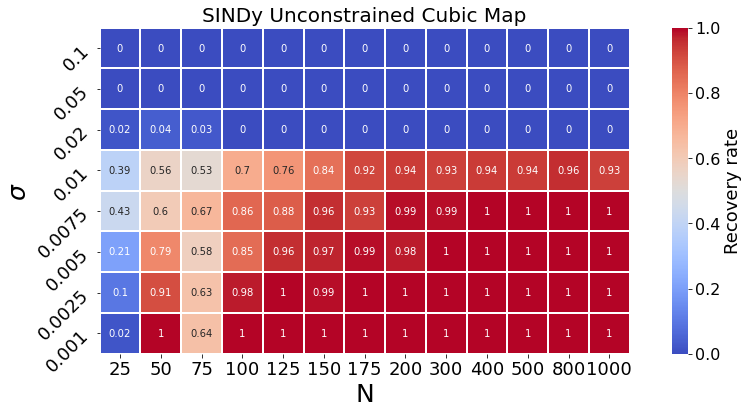

In [39]:
heatmap_data = np.array([results_cubic_sindy_uncon[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Recovery rate', fontsize=18)
plt.title('SINDy Unconstrained Cubic Map', fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

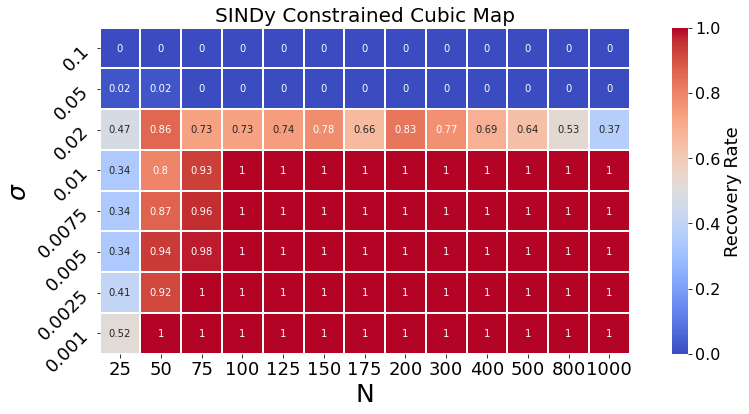

In [40]:
heatmap_data = np.array([results_cubic_sindy_con[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Recovery Rate', fontsize=18)
plt.title('SINDy Constrained Cubic Map', fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

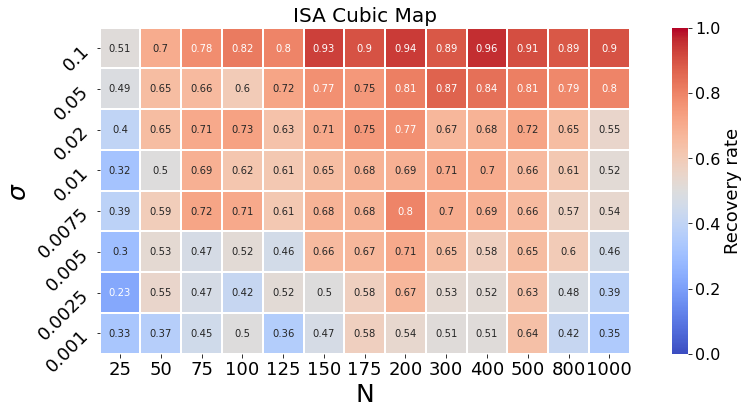

In [41]:
heatmap_data = np.array([results_cubic_isa[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Recovery rate', fontsize=18)
plt.title('ISA Cubic Map', fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

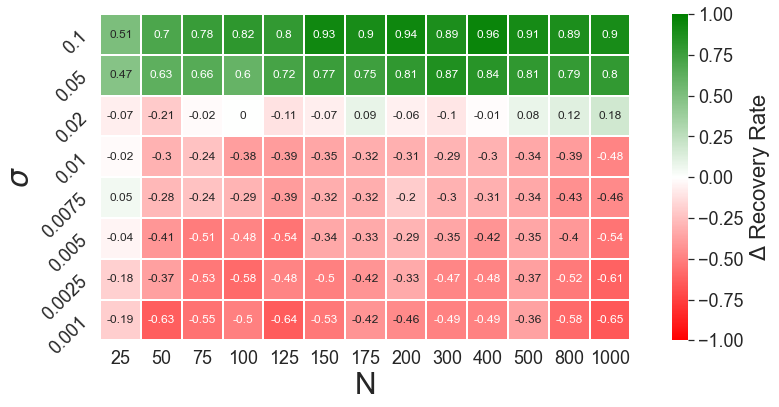

In [910]:
results_method1 = np.array([results_cubic_sindy_con[eta] for eta in etas])
results_method2 = np.array([results_cubic_isa[eta] for eta in etas])

# compute the difference
performance_difference = results_method2 - results_method1

colors = ['red', 'white', 'green']
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# display as a single heatmap
plt.figure(figsize=(15, 6))
#plt.title('Cubic Map', fontsize=20)
heatmap = sns.heatmap(performance_difference, annot=True, cmap=cmap, xticklabels=Ns, yticklabels=etas, cbar_kws={'label': '$\Delta$ Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=-1, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('$\Delta$ Recovery Rate', fontsize=22)
cbar.ax.tick_params(labelsize=18)
plt.xlabel('N', fontsize=30)
plt.ylabel('$\sigma$', fontsize=30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
#plt.savefig('cubic_map_sindy_vs_tsfabc.svg', transparent=True)
#plt.show()

Interestingly, SINDy outpeforms our method in the low noise regime for all N, but out method outperforms SINDy in the high noise regime for all N with a trend toward high recovery rates. This may warrant further investigation.

------------

## Henon Map

In [43]:
Ns = [25, 50, 75, 100, 125, 150, 175, 200, 300, 400, 500, 800, 1000]  # time series lengths
etas = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.02, 0.05, 0.1]  # list of eta values
optimal_lambda_uncon = 0.1
optimal_lambda_con = 0.107
model1 = ps.SINDy(feature_library=unconstrained_lib, feature_names=['x','y', 'mu'], discrete_time=True, optimizer=ps.STLSQ(threshold=optimal_lambda_uncon))
model2 = ps.SINDy(feature_library=constrained_lib, feature_names=['x', 'y', 'mu'], discrete_time=True, optimizer=ps.STLSQ(threshold=optimal_lambda_con))
n_iter = 100
results_henon_sindy_uncon = dict()
results_henon_sindy_con = dict()
results_henon_isa = dict()

for eta in etas:
    n_identifications_sindy_uncon = list()
    n_identifications_sindy_con = list()
    n_identifications_isa = list()
    for n in Ns:
        identifications_sindy_uncon = list()
        identifications_sindy_con = list()
        identifications_isa = list()
        for i in range(n_iter):
            df_test, ts_test = generate_HenonMap(n, eta)
            identifications_sindy_uncon.append(isHenonMap_sindy(ts_test, model1, tol=0.1))
            identifications_sindy_con.append(isHenonMap_sindy(ts_test, model2, tol=0.1))
            identifications_isa.append(isMap_isa(space, 'HenonMap', df_test, ts_test))
        non_zero_sindy_uncon = np.count_nonzero(identifications_sindy_uncon)
        non_zero_sindy_con = np.count_nonzero(identifications_sindy_con)
        non_zero_isa = np.count_nonzero(identifications_isa)
        n_identifications_sindy_uncon.append(non_zero_sindy_uncon)
        n_identifications_sindy_con.append(non_zero_sindy_con)
        n_identifications_isa.append(non_zero_isa)
    fraction_identified_sindy_uncon = np.array(n_identifications_sindy_uncon) / n_iter
    fraction_identified_sindy_con = np.array(n_identifications_sindy_con) / n_iter
    fraction_identified_isa = np.array(n_identifications_isa) / n_iter
    results_henon_sindy_uncon[eta] = fraction_identified_sindy_uncon
    results_henon_sindy_con[eta] = fraction_identified_sindy_con
    results_henon_isa[eta] = fraction_identified_isa

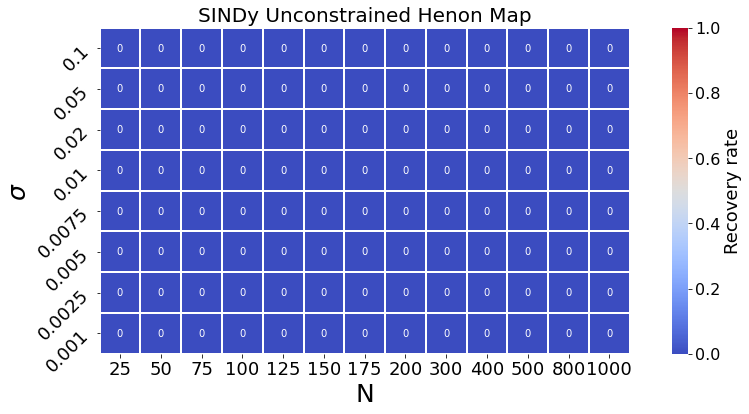

In [44]:
heatmap_data = np.array([results_henon_sindy_uncon[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Recovery rate', fontsize=18)
plt.title('SINDy Unconstrained Henon Map', fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

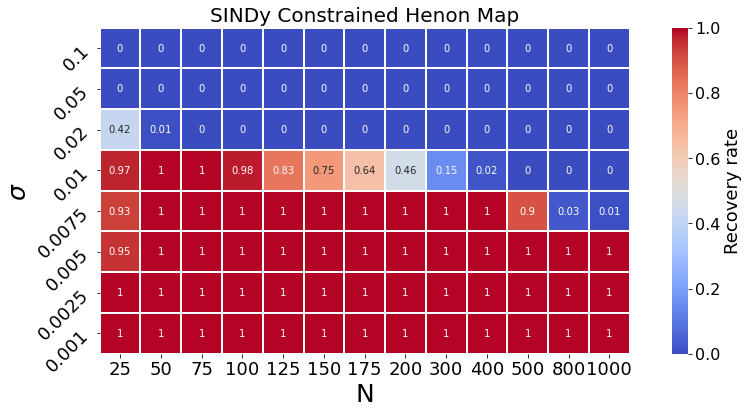

In [45]:
heatmap_data = np.array([results_henon_sindy_con[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Recovery rate', fontsize=18)
plt.title('SINDy Constrained Henon Map', fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

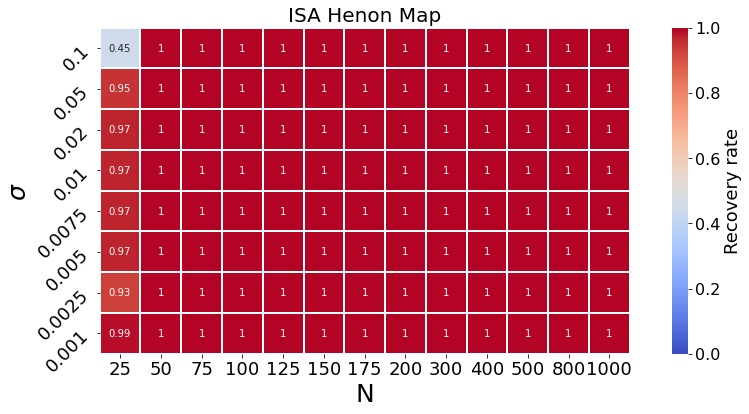

In [46]:
heatmap_data = np.array([results_henon_isa[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Recovery rate', fontsize=18)
plt.title('ISA Henon Map', fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

## Compute Differnce

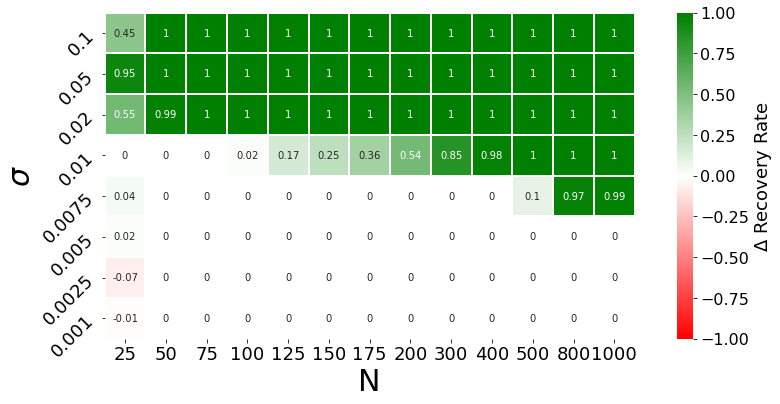

In [47]:
results_method1 = np.array([results_henon_sindy_con[eta] for eta in etas])
results_method2 = np.array([results_henon_isa[eta] for eta in etas])

# compute the difference
performance_difference = results_method2 - results_method1

colors = ['red', 'white', 'green']
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# display as a single heatmap
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(performance_difference, annot=True, cmap=cmap, xticklabels=Ns, yticklabels=etas, cbar_kws={'label': '$\Delta$ Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=-1, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('$\Delta$ Recovery Rate', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=30)
plt.ylabel('$\sigma$', fontsize=30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

--------

## Burgers' Map

In [48]:
Ns = [25, 50, 75, 100, 125, 150, 175, 200, 300, 400, 500, 800, 1000]  # time series lengths
etas = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.02, 0.05, 0.1]  # list of eta values
optimal_lambda_uncon = 0.1
optimal_lambda_con = 0.107
model1 = ps.SINDy(feature_library=unconstrained_lib, feature_names=['x','y', 'mu'], discrete_time=True, optimizer=ps.STLSQ(threshold=optimal_lambda_uncon))
model2 = ps.SINDy(feature_library=constrained_lib, feature_names=['x', 'y', 'mu'], discrete_time=True, optimizer=ps.STLSQ(threshold=optimal_lambda_con))
n_iter = 100
results_burgers_sindy_uncon = dict()
results_burgers_sindy_con = dict()
results_burgers_isa = dict()

for eta in etas:
    n_identifications_sindy_uncon = list()
    n_identifications_sindy_con = list()
    n_identifications_isa = list()
    for n in Ns:
        identifications_sindy_uncon = list()
        identifications_sindy_con = list()
        identifications_isa = list()
        for i in range(n_iter):
            df_test, ts_test = generate_BurgersMap(n, eta)
            identifications_sindy_uncon.append(isBurgersMap_sindy(ts_test, model1, tol=0.1))
            identifications_sindy_con.append(isBurgersMap_sindy(ts_test, model2, tol=0.1))
            identifications_isa.append(isMap_isa(space, 'BurgersMap', df_test, ts_test))
        non_zero_sindy_uncon = np.count_nonzero(identifications_sindy_uncon)
        non_zero_sindy_con = np.count_nonzero(identifications_sindy_con)
        non_zero_isa = np.count_nonzero(identifications_isa)
        n_identifications_sindy_uncon.append(non_zero_sindy_uncon)
        n_identifications_sindy_con.append(non_zero_sindy_con)
        n_identifications_isa.append(non_zero_isa)
    fraction_identified_sindy_uncon = np.array(n_identifications_sindy_uncon) / n_iter
    fraction_identified_sindy_con = np.array(n_identifications_sindy_con) / n_iter
    fraction_identified_isa = np.array(n_identifications_isa) / n_iter
    results_burgers_sindy_uncon[eta] = fraction_identified_sindy_uncon
    results_burgers_sindy_con[eta] = fraction_identified_sindy_con
    results_burgers_isa[eta] = fraction_identified_isa

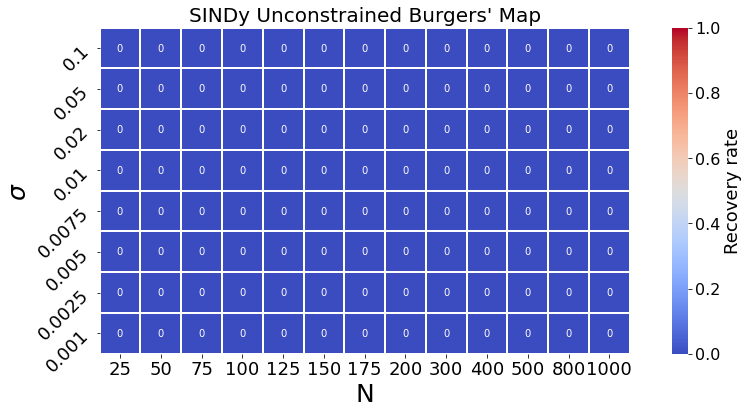

In [49]:
heatmap_data = np.array([results_burgers_sindy_uncon[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Recovery rate', fontsize=18)
plt.title("SINDy Unconstrained Burgers' Map", fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

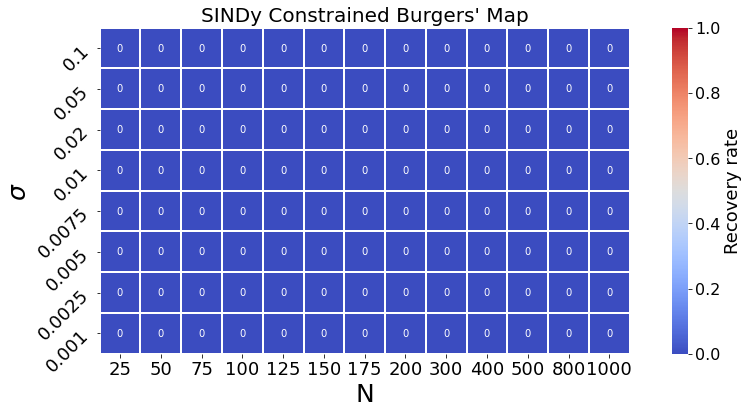

In [50]:
heatmap_data = np.array([results_burgers_sindy_con[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Recovery rate', fontsize=18)
plt.title("SINDy Constrained Burgers' Map", fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

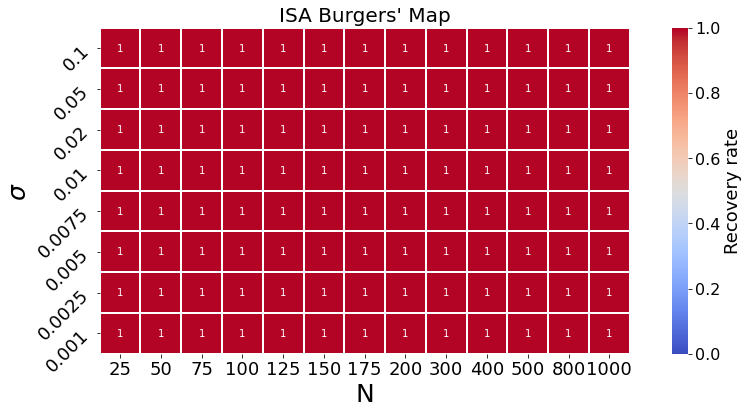

In [51]:
heatmap_data = np.array([results_burgers_isa[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Recovery rate', fontsize=18)
plt.title("ISA Burgers' Map", fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

### Compute difference

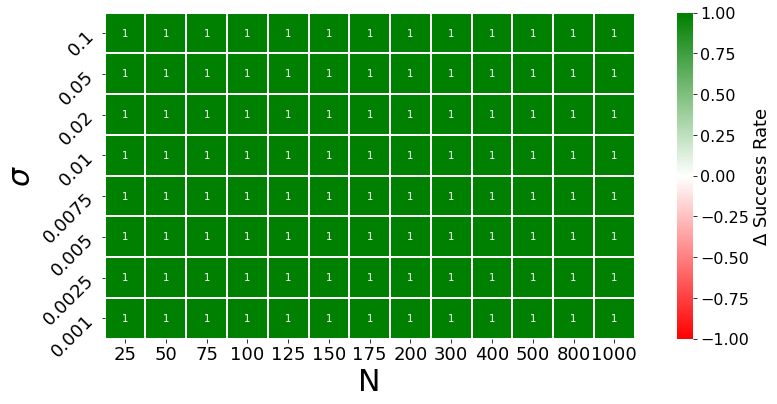

In [52]:
results_method1 = np.array([results_burgers_sindy_con[eta] for eta in etas])
results_method2 = np.array([results_burgers_isa[eta] for eta in etas])

# compute the difference
performance_difference = results_method2 - results_method1

colors = ['red', 'white', 'green']
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# display as a single heatmap
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(performance_difference, annot=True, cmap=cmap, xticklabels=Ns, yticklabels=etas, cbar_kws={'label': '$\Delta$ Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=-1, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('$\Delta$ Success Rate', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=30)
plt.ylabel('$\sigma$', fontsize=30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

--------

# TinkerBell Map

In [53]:
Ns = [25, 50, 75, 100, 125, 150, 175, 200, 300, 400, 500, 800, 1000]  # time series lengths
etas = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.02, 0.05, 0.1]  # list of eta values
optimal_lambda_uncon = 0.1
optimal_lambda_con = 0.107
model1 = ps.SINDy(feature_library=unconstrained_lib, feature_names=['x','y', 'mu'], discrete_time=True, optimizer=ps.STLSQ(threshold=optimal_lambda_uncon))
model2 = ps.SINDy(feature_library=constrained_lib, feature_names=['x', 'y', 'mu'], discrete_time=True, optimizer=ps.STLSQ(threshold=optimal_lambda_con))
n_iter = 100
results_tinkerbell_sindy_uncon = dict()
results_tinkerbell_sindy_con = dict()
results_tinkerbell_isa = dict()

for eta in etas:
    n_identifications_sindy_uncon = list()
    n_identifications_sindy_con = list()
    n_identifications_isa = list()
    for n in Ns:
        identifications_sindy_uncon = list()
        identifications_sindy_con = list()
        identifications_isa = list()
        for i in range(n_iter):
            df_test, ts_test = generate_TinkerBellMap(n, eta)
            identifications_sindy_uncon.append(isTinkerBellMap_sindy(ts_test, model1, tol=0.1))
            identifications_sindy_con.append(isTinkerBellMap_sindy(ts_test, model2, tol=0.1))
            identifications_isa.append(isMap_isa(space, 'TinkerBellMap', df_test, ts_test))
        non_zero_sindy_uncon = np.count_nonzero(identifications_sindy_uncon)
        non_zero_sindy_con = np.count_nonzero(identifications_sindy_con)
        non_zero_isa = np.count_nonzero(identifications_isa)
        n_identifications_sindy_uncon.append(non_zero_sindy_uncon)
        n_identifications_sindy_con.append(non_zero_sindy_con)
        n_identifications_isa.append(non_zero_isa)
    fraction_identified_sindy_uncon = np.array(n_identifications_sindy_uncon) / n_iter
    fraction_identified_sindy_con = np.array(n_identifications_sindy_con) / n_iter
    fraction_identified_isa = np.array(n_identifications_isa) / n_iter
    results_tinkerbell_sindy_uncon[eta] = fraction_identified_sindy_uncon
    results_tinkerbell_sindy_con[eta] = fraction_identified_sindy_con
    results_tinkerbell_isa[eta] = fraction_identified_isa

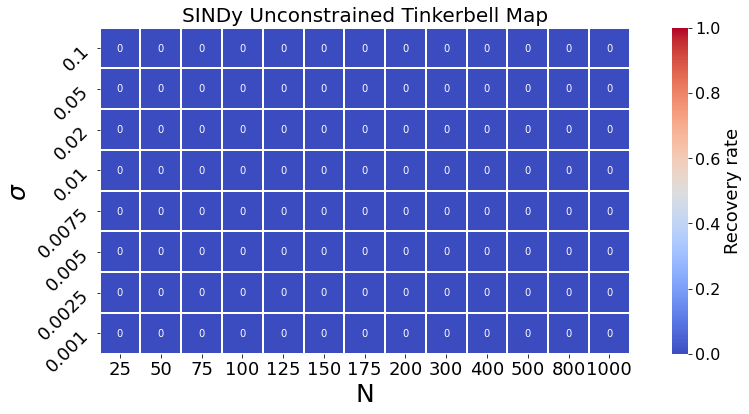

In [54]:
heatmap_data = np.array([results_tinkerbell_sindy_uncon[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Recovery rate', fontsize=18)
plt.title("SINDy Unconstrained Tinkerbell Map", fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

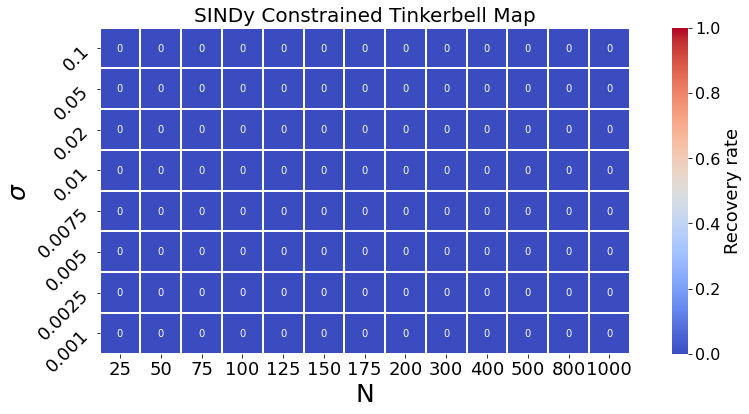

In [55]:
heatmap_data = np.array([results_tinkerbell_sindy_con[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Recovery rate', fontsize=18)
plt.title("SINDy Constrained Tinkerbell Map", fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

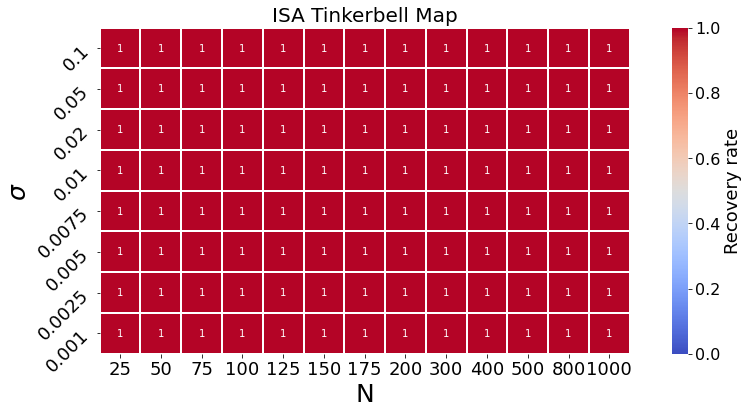

In [56]:
heatmap_data = np.array([results_tinkerbell_isa[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Recovery rate', fontsize=18)
plt.title("ISA Tinkerbell Map", fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

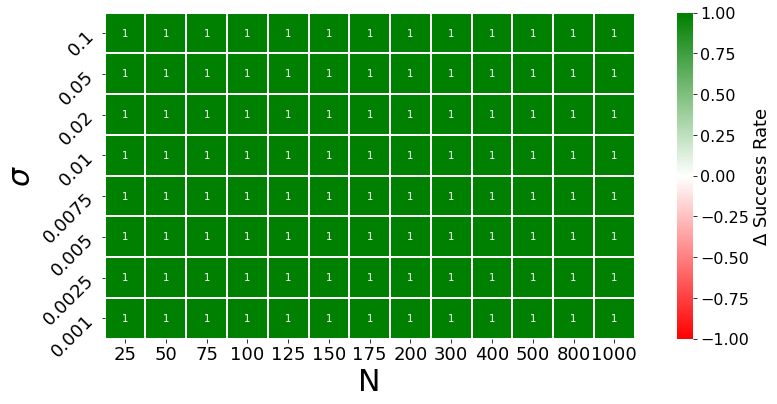

In [57]:
results_method1 = np.array([results_tinkerbell_sindy_con[eta] for eta in etas])
results_method2 = np.array([results_tinkerbell_isa[eta] for eta in etas])

# compute the difference
performance_difference = results_method2 - results_method1

colors = ['red', 'white', 'green']
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# display as a single heatmap
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(performance_difference, annot=True, cmap=cmap, xticklabels=Ns, yticklabels=etas, cbar_kws={'label': '$\Delta$ Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=-1, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('$\Delta$ Success Rate', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=30)
plt.ylabel('$\sigma$', fontsize=30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

### Distill results into a single bar plot

focus on range of N from 25 to 200 and sigma from 0.01 to 0.1 and compute the average recovery rates across the range

In [58]:
def compute_average(data):
    ## compute the average across all values of N and eta for each case of ISA, SINDy unconstrained, and SINDy constrained
    total_sum = 0
    total_values = 0
    for array in data.values():
        total_sum += sum(array)
        total_values += len(array)
    return total_sum / total_values

In [59]:
# log map 
sindy_uncon_log = compute_average(results_log_sindy_uncon)
sindy_con_log = compute_average(results_log_sindy_con)
isa_log = compute_average(results_log_isa)
# tinkerbell map
sindy_uncon_tinkerbell = compute_average(results_tinkerbell_sindy_uncon)
sindy_con_tinkerbell = compute_average(results_tinkerbell_sindy_con)
isa_tinkerbell = compute_average(results_tinkerbell_isa)
# cubic map
sindy_uncon_cubic = compute_average(results_cubic_sindy_uncon)
sindy_con_cubic = compute_average(results_cubic_sindy_con)
isa_cubic = compute_average(results_cubic_isa)
# henon map
sindy_uncon_henon = compute_average(results_henon_sindy_uncon)
sindy_con_henon = compute_average(results_henon_sindy_con)
isa_henon = compute_average(results_henon_isa)
# burgers map
sindy_uncon_burgers = compute_average(results_burgers_sindy_uncon)
sindy_con_burgers = compute_average(results_burgers_sindy_con)
isa_burgers = compute_average(results_burgers_isa)

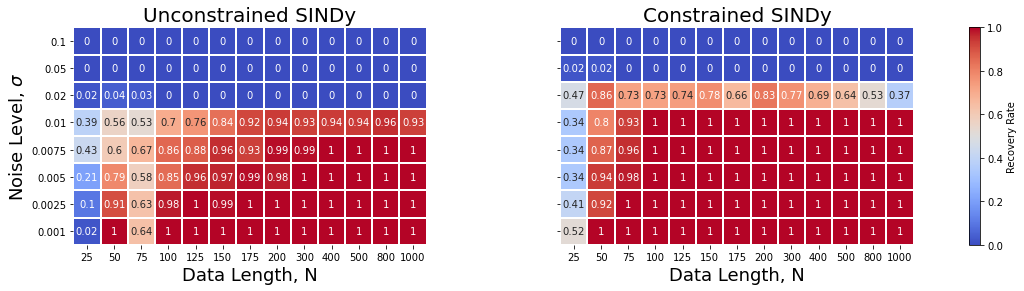

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4), sharey=True)
heatmap_data_sindy = np.array([results_cubic_sindy_uncon[eta] for eta in etas])
heatmap_data_sindy_con = np.array([results_cubic_sindy_con[eta] for eta in etas])


# Remove cbar_kws from both heatmaps
heatmap1 = sns.heatmap(heatmap_data_sindy, annot=True, cmap='coolwarm', xticklabels=Ns, yticklabels=etas, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1, ax=ax[0], cbar=False)
heatmap2 = sns.heatmap(heatmap_data_sindy_con, annot=True, cmap='coolwarm', xticklabels=Ns, yticklabels=etas, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1, ax=ax[1], cbar=False)

ax[0].set_xlabel('Data Length, N', fontsize=18)
ax[1].set_xlabel('Data Length, N', fontsize=18)
ax[0].set_ylabel('Noise Level, $\sigma$', fontsize=18)
# Create a common colorbar for both heatmaps
norm = plt.Normalize(heatmap_data_sindy.min(), heatmap_data_sindy.max())
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), label='Recovery Rate')

ax[0].set_title('Unconstrained SINDy', fontsize=20)
ax[1].set_title('Constrained SINDy', fontsize=20)
heatmap1.invert_yaxis()

plt.show()


## Averages for each case (SINDy and our method)

In [61]:
results_tinkerbell_isa 
isa_averages = {}
sindy_constrained_averages = {}
sindy_unconstrained_averages = {}
for key in results_tinkerbell_isa:
    isa_averages[key] = (results_tinkerbell_isa[key] + results_henon_isa[key] + results_cubic_isa[key] + results_burgers_isa[key] + results_log_isa[key]) / 5
    sindy_constrained_averages[key] = (results_tinkerbell_sindy_con[key] + results_henon_sindy_con[key] + results_cubic_sindy_con[key] + results_burgers_sindy_con[key] + results_log_sindy_con[key]) / 5
    sindy_unconstrained_averages[key] = (results_tinkerbell_sindy_uncon[key] + results_henon_sindy_uncon[key] + results_cubic_sindy_uncon[key] + results_burgers_sindy_uncon[key] + results_log_sindy_uncon[key]) / 5

Now let's do a side-by-side comparison..

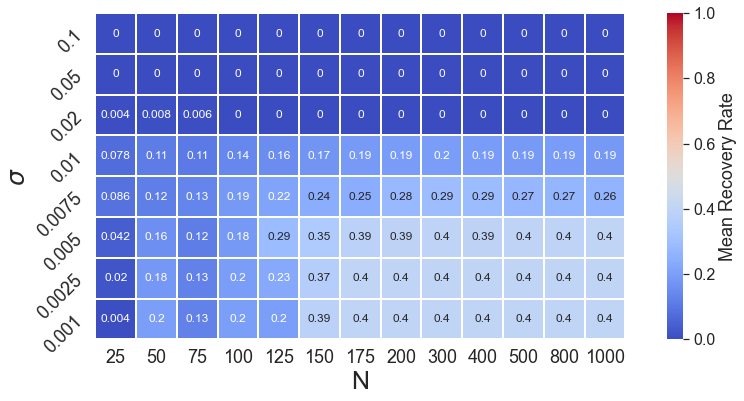

In [913]:
heatmap_data = np.array([sindy_unconstrained_averages[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Mean Recovery Rate', fontsize=18)
#plt.title("Unconstrained SINDy Average Performance", fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
#plt.savefig('unconstrained_sindy_average_performance.svg', transparent=True)
plt.show()

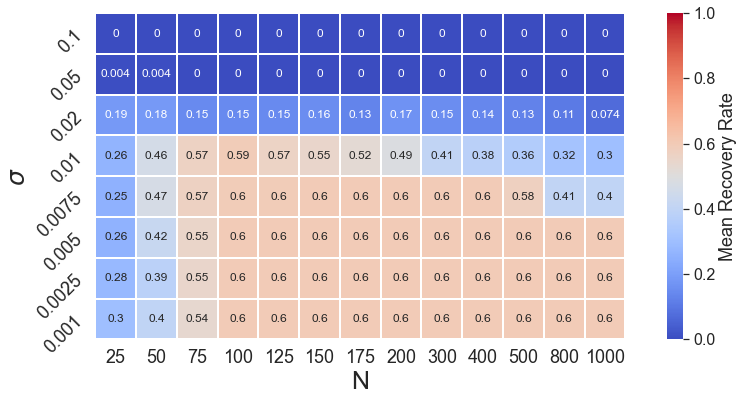

In [914]:
heatmap_data = np.array([sindy_constrained_averages[eta] for eta in etas])
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Mean Recovery Rate', fontsize=18)
#plt.title("Constrained SINDy Average Performance", fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.savefig('constrained_sindy_average_performance.svg', transparent=True)
#plt.show()

Diff between SINDy variants

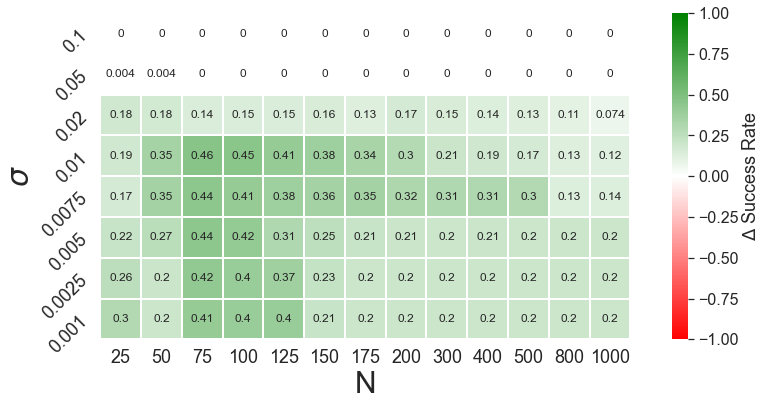

In [912]:
results_method2 = np.array([sindy_constrained_averages[eta] for eta in etas])
results_method1 = np.array([sindy_unconstrained_averages[eta] for eta in etas])

# compute the difference
performance_difference = results_method2 - results_method1

colors = ['red', 'white', 'green']
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# display as a single heatmap
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(performance_difference, annot=True, cmap=cmap, xticklabels=Ns, yticklabels=etas, cbar_kws={'label': '$\Delta$ Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=-1, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('$\Delta$ Success Rate', fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=30)
plt.ylabel('$\sigma$', fontsize=30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.show()

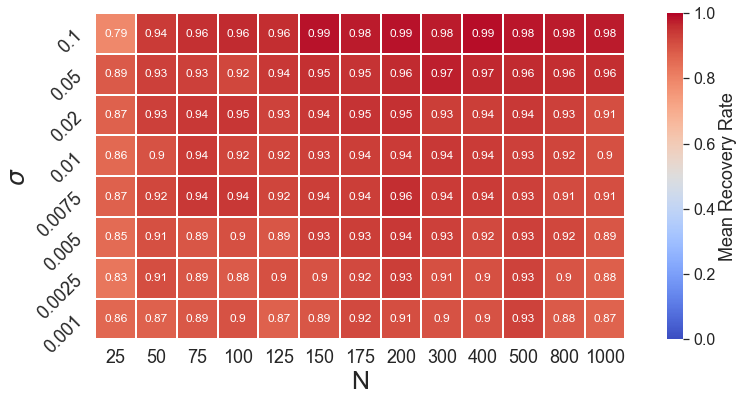

In [921]:
heatmap_data = np.array([isa_averages[eta] for eta in etas])
fig, ax = plt.subplots(1,1, figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',xticklabels=Ns, yticklabels=etas,  cbar_kws={'label': 'Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1, ax=ax)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Mean Recovery Rate', fontsize=18)
#plt.title("Feature Space Average Performance", fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=25)
plt.ylabel('$\sigma$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
#plt.savefig('feature_space_average_performance.svg', transparent=True)
plt.show()

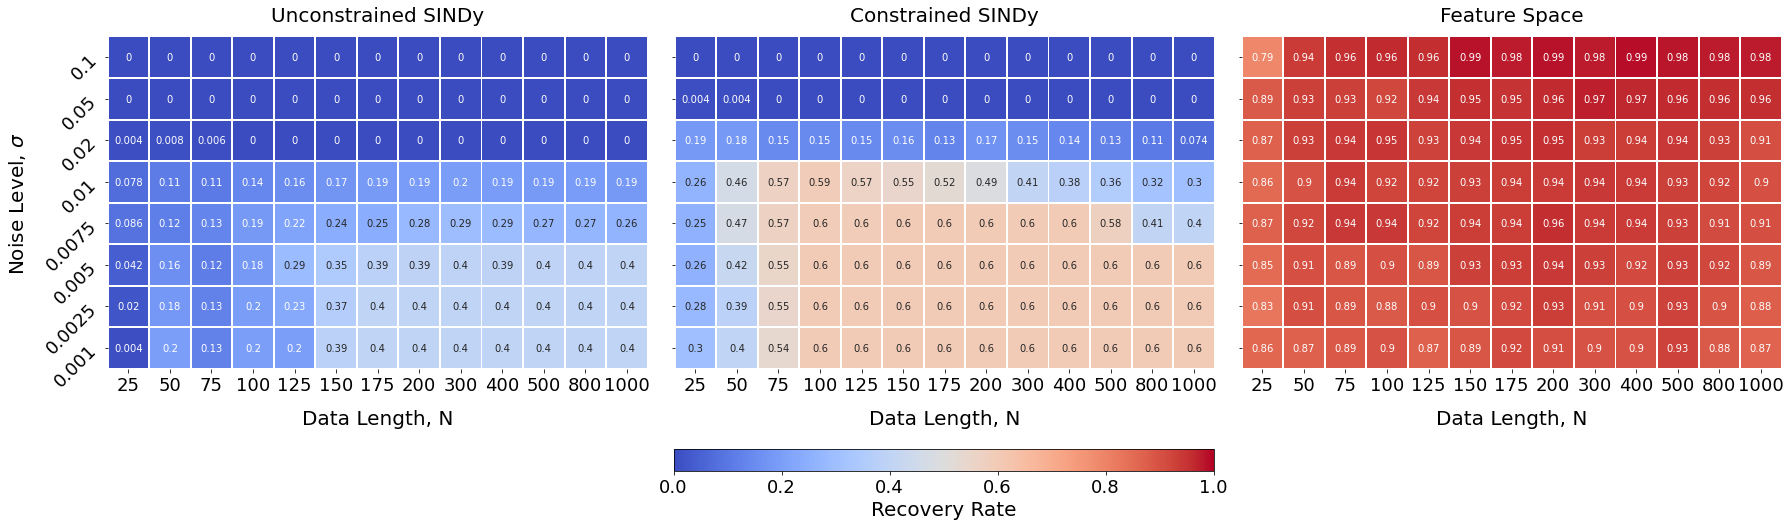

In [103]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10), sharey=True)
fig.subplots_adjust(wspace=0.05)
heatmap_data_sindy = np.array([sindy_unconstrained_averages[eta] for eta in etas])
heatmap_data_sindy_con = np.array([sindy_constrained_averages[eta] for eta in etas])
heatmap_data_isa = np.array([isa_averages[eta] for eta in etas])

# Remove cbar_kws from both heatmaps
heatmap1 = sns.heatmap(heatmap_data_sindy, annot=True, cmap='coolwarm', xticklabels=Ns, yticklabels=etas, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1, ax=ax[0], cbar=False)
heatmap2 = sns.heatmap(heatmap_data_sindy_con, annot=True, cmap='coolwarm', xticklabels=Ns, yticklabels=etas, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1, ax=ax[1], cbar=False)
heatmap3 = sns.heatmap(heatmap_data_isa, annot=True, cmap='coolwarm', xticklabels=Ns, yticklabels=etas, linewidth=1, linecolor='w', square=True, vmin=0, vmax=1, ax=ax[2], cbar=False)
labelpad = 15
ax[0].set_xlabel('Data Length, N', fontsize=20, labelpad=labelpad)
ax[1].set_xlabel('Data Length, N', fontsize=20, labelpad=labelpad)
ax[2].set_xlabel('Data Length, N', fontsize=20, labelpad=labelpad)
ax[0].set_ylabel('Noise Level, $\sigma$', fontsize=20, labelpad=labelpad)
ax[0].set_yticklabels(etas, rotation=45)

cbar_ax = fig.add_axes([0.387, 0.13, 0.25, 0.03])

# Create a common colorbar for both heatmaps
norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', shrink=0.1, pad=0.01)
cbar.set_label('Recovery Rate', fontsize=20)
cbar.ax.tick_params(labelsize=18)

for axis in ax:
    axis.tick_params(axis='x', labelsize=18)

ax[0].tick_params(axis='y', labelsize=18)


ax[0].set_title('Unconstrained SINDy', fontsize=20, pad=15)
ax[1].set_title('Constrained SINDy', fontsize=20, pad=15)
ax[2].set_title('Feature Space', fontsize=20, pad=15)
heatmap1.invert_yaxis()

plt.savefig('heatmap_averages.png', dpi=900, bbox_inches='tight')

Difference between feature space and SINDy

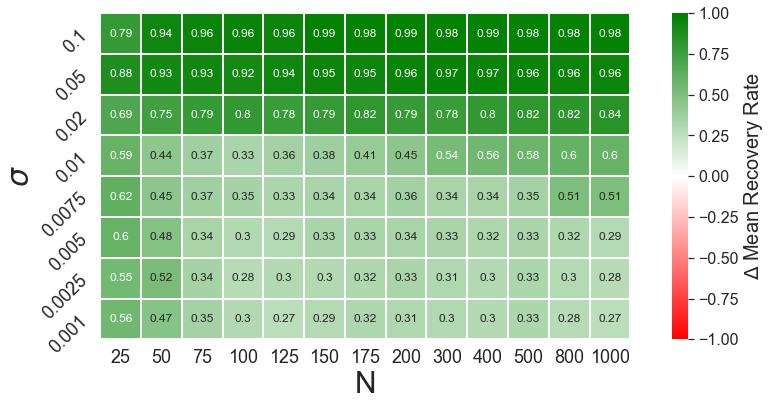

In [918]:
results_method2 = np.array([sindy_constrained_averages[eta] for eta in etas])
results_method1 = np.array([isa_averages[eta] for eta in etas])

# compute the difference
performance_difference = results_method1 - results_method2

colors = ['red', 'white', 'green']
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# display as a single heatmap
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(performance_difference, annot=True, cmap=cmap, xticklabels=Ns, yticklabels=etas, cbar_kws={'label': '$\Delta$ Fraction Identified'}, linewidth=1, linecolor='w', square=True, vmin=-1, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('$\Delta$ Mean Recovery Rate', fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.xlabel('N', fontsize=30)
plt.ylabel('$\sigma$', fontsize=30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=45)
heatmap.invert_yaxis()
plt.savefig('sindy_con_vs_feature_space.svg', transparent=True)
#plt.show()

## Examine Cubic Map Selection in Low-Data High Noise Regime

Choose N = 50, sigma = 0.001, sigma = 0.01, and sigma = 0.1

Determine which map(s) are confused with the cubic map and how often

In [863]:
from collections import defaultdict

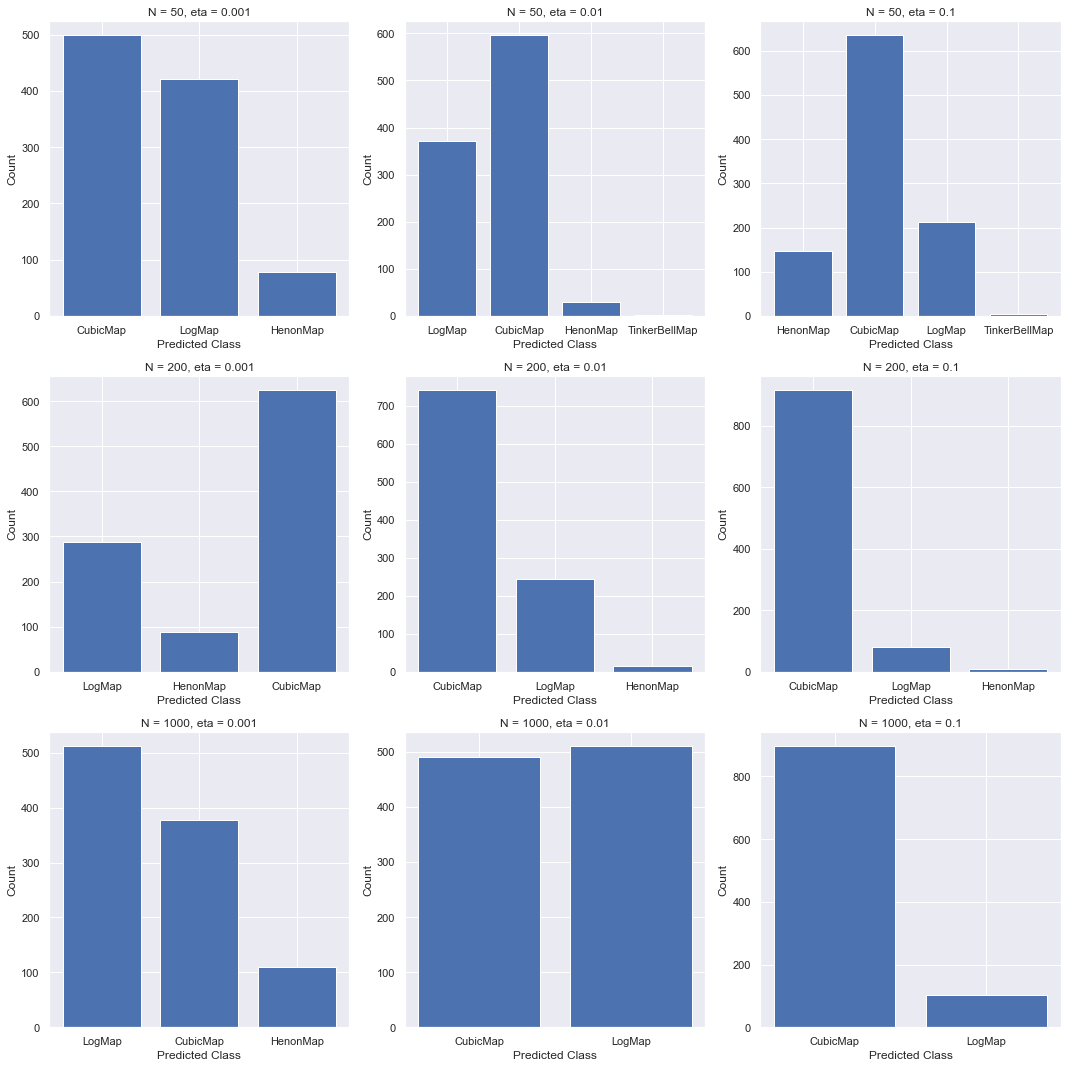

In [865]:
N_vals = [50, 200, 1000]
eta_vals = [0.001, 0.01, 0.1]  
iterations = 1000

results = defaultdict(lambda: defaultdict(list))

for i in range(iterations):
    for N in N_vals:
        for eta in eta_vals:
            df_cubic_exp, ts_cubic_exp = generate_CubicMap(N_val=N, eta_val=eta)
            probs, preds, classes = space.predict(df_cubic_exp, ts_cubic_exp)
            avg_probs = np.mean(probs, axis=0)  
            avg_index = np.argmax(avg_probs)
            predicted_class = classes[avg_index] 
            results[N][eta].append(predicted_class)

# Create bar plots
fig, axs = plt.subplots(len(N_vals), len(eta_vals), figsize=(15,15))

for i, N in enumerate(N_vals):
    for j, eta in enumerate(eta_vals):
        counts = defaultdict(int)
        for predicted_class in results[N][eta]:
            counts[predicted_class] += 1
        axs[i, j].bar(counts.keys(), counts.values())
        axs[i, j].set_title(f'N = {N}, eta = {eta}')
        axs[i, j].set_xlabel('Predicted Class')
        axs[i, j].set_ylabel('Count')

plt.tight_layout()
plt.show()





In [898]:
from collections import Counter

In [902]:
count_dict1 = Counter(results[50][0.001])
count_dict2 = Counter(results[50][0.01])
count_dict3 = Counter(results[50][0.1])

print(f'N=50, sigma = 0.001: {count_dict1}')
print(f'N=50, sigma = 0.01: {count_dict2}')
print(f'N=50, sigma = 0.1: {count_dict3}')

N=50, sigma = 0.001: Counter({'CubicMap': 500, 'LogMap': 422, 'HenonMap': 78})
N=50, sigma = 0.01: Counter({'CubicMap': 597, 'LogMap': 371, 'HenonMap': 29, 'TinkerBellMap': 3})
N=50, sigma = 0.1: Counter({'CubicMap': 636, 'LogMap': 212, 'HenonMap': 148, 'TinkerBellMap': 4})


In [905]:
count_dict1 = Counter(results[200][0.001])
count_dict2 = Counter(results[200][0.01])
count_dict3 = Counter(results[200][0.1])

print(f'N=200, sigma = 0.001: {count_dict1}')
print(f'N=200, sigma = 0.01: {count_dict2}')
print(f'N=200, sigma = 0.1: {count_dict3}')

N=200, sigma = 0.001: Counter({'CubicMap': 624, 'LogMap': 288, 'HenonMap': 88})
N=200, sigma = 0.01: Counter({'CubicMap': 740, 'LogMap': 244, 'HenonMap': 16})
N=200, sigma = 0.1: Counter({'CubicMap': 914, 'LogMap': 79, 'HenonMap': 7})


In [906]:
count_dict1 = Counter(results[1000][0.001])
count_dict2 = Counter(results[1000][0.01])
count_dict3 = Counter(results[1000][0.1])

print(f'N=1000, sigma = 0.001: {count_dict1}')
print(f'N=1000, sigma = 0.01: {count_dict2}')
print(f'N=1000, sigma = 0.1: {count_dict3}')

N=1000, sigma = 0.001: Counter({'LogMap': 512, 'CubicMap': 378, 'HenonMap': 110})
N=1000, sigma = 0.01: Counter({'LogMap': 510, 'CubicMap': 490})
N=1000, sigma = 0.1: Counter({'CubicMap': 896, 'LogMap': 104})


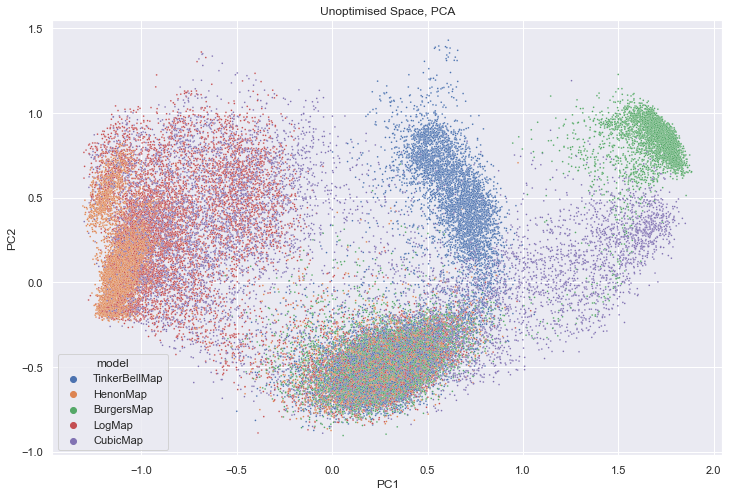

In [866]:
embeddings_explore = space.pcaViz(return_df=True)

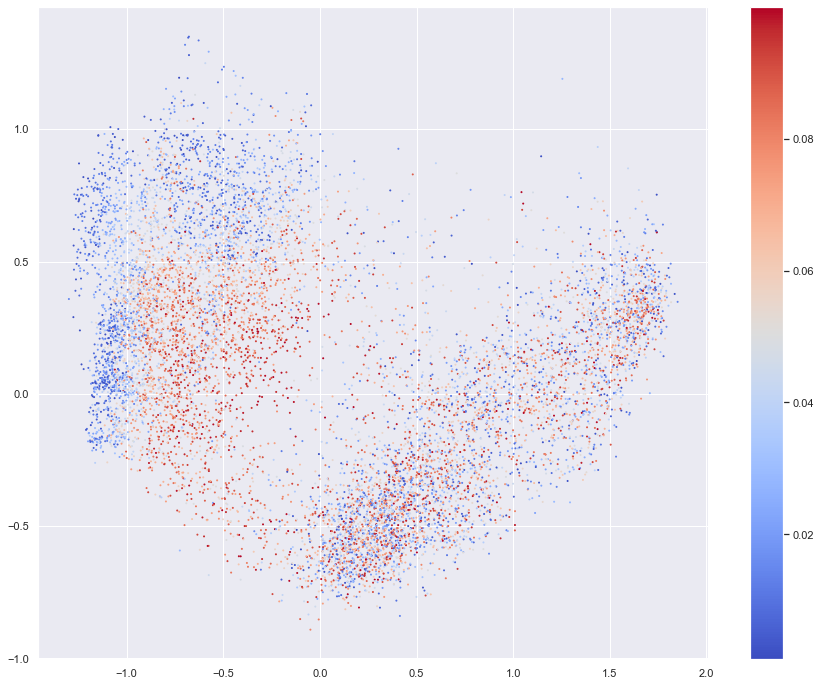

In [881]:
plt.figure(figsize=(15,12))
plt.scatter(embeddings_explore[embeddings_explore['model'] == 'CubicMap']['PC1'], embeddings_explore[embeddings_explore['model'] == 'CubicMap']['PC2'], c=embeddings_explore[embeddings_explore['model'] == 'CubicMap']['eta'], cmap='coolwarm', s=1)
plt.colorbar()

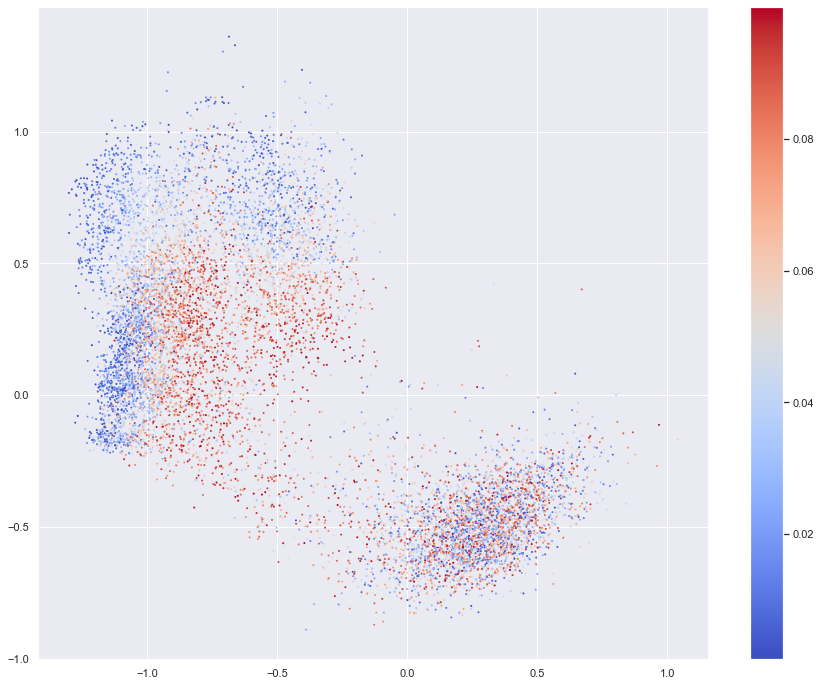

In [882]:
plt.figure(figsize=(15,12))
plt.scatter(embeddings_explore[embeddings_explore['model'] == 'LogMap']['PC1'], embeddings_explore[embeddings_explore['model'] == 'LogMap']['PC2'], c=embeddings_explore[embeddings_explore['model'] == 'LogMap']['eta'], cmap='coolwarm', s=1)
plt.colorbar()

Both the logistic and cubic maps have significant overlap in PCA space, particularly in the low noise regime. This could potentially be leading to misattribution of the cubic map to the logistic map.